# Twitter Sentiment Analysis

# Data Management

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import nltk
nltk.download("popular")
!pip install wandb --upgrade
!wandb login
import wandb
%env WANDB_SILENT=true

In [ ]:
import os
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

data_path = "/content/drive/My Drive/AIII/ergasia1"

# open csv as dataframes
train_df = pd.read_csv(data_path+"/SentimentTweets.csv")

# train_df = train_df[0:1000]
train_df.target.replace({4: 1}, inplace=True)

x_train, x_test, y_train, y_test = train_test_split(train_df, train_df.target, test_size=0.05, shuffle=True, stratify=train_df.target)
x_validation, x_test, y_validation, y_test = train_test_split(x_test, x_test.target, test_size=0.5, shuffle=True, stratify=x_test.target)

x_train_corpus = list(x_train["text"])
y_train_list = list(x_train["target"].astype(int))

x_validation_corpus = list(x_validation["text"])
y_validation_list = list(x_validation["target"].astype(int))

x_test_corpus = list(x_test["text"])
y_test_list = list(x_test["target"].astype(int))

train_df.head(10)

Unnamed: 0  ...                                               text
0      680949  ...                                #brokenpromises... 
1      406741  ...  David Carradine  so sad. Thai's law not sure i...
2     1337108  ...    A @ 415 B @ 425. Tell your bro i say congrats! 
3     1560887  ...                          @littlefluffycat  Indeed.
4     1466295  ...  Completed Race 4 Life in 58mins with girlies f...
5      725609  ...  Woot truck fixed!!! Now workin  http://myloc.m...
6     1361765  ...            @BLAQSHEEPCEO   yea I melt at that lol 
7      114606  ...  wants to do something radical...but not sure w...
8      620064  ...  @brlamb scratch that, @bgilgoff tweeted it. Ch...
9      564150  ...  I am sore everywhere. Also found out an assess...

[10 rows x 7 columns]

# Text sanitization 


with the following procedures

 1.      Convert letters to lowercase

 2. Remove the links with the normal expression "http \ S +" which removes all the words that start with "http" until the first white character "S +" is found, ie until this word ends, the link in our case

3. Remove links with the normal expression "@ [A-Za-z0–9] +" which removes all words beginning with "@" until the first white character that is not a letter or number is found


 4. Remove other characters that have no information such as / xa0 and change line \ n


 5. Remove the support points with string.punctuation and str.translate

 6. Removing gaps ""
 
 7. Subtraction of stop words

In [ ]:
import string
import re


def clean_text_syntax_links(corpus, y):

    for tweet in range(len(corpus)):
        # # lower case latters
        # corpus[tweet] = corpus[tweet].lower()
        # remove links with regular expression 
        corpus[tweet] = re.sub(r'http\S+', " ", corpus[tweet])
        # remove mentions @...
        corpus[tweet] = re.sub('@[A-Za-z0–9]+', '', corpus[tweet])
        # remove garbage characters xa0
        corpus[tweet] = corpus[tweet].replace("\\xa0"," ").replace("\xa0"," ").replace("\\xc2"," ").replace("\xc2"," ").replace("\n"," ").strip()
        # remove syntax
        corpus[tweet] = corpus[tweet].translate(str.maketrans('', '', string.punctuation))

    # remove empy ones
    # corpus = list(filter(None, corpus))
    for i, data in enumerate(corpus):
        if data == "" or data == " ":
            del corpus[i]
            del y[i]

    return corpus, y


x_train_corpus, y_train_list           = clean_text_syntax_links(x_train_corpus, y_train_list)
x_validation_corpus, y_validation_list = clean_text_syntax_links(x_validation_corpus, y_validation_list)
x_test_corpus, y_test_list             = clean_text_syntax_links(x_test_corpus, y_test_list)

x_train_corpus_raw = x_train_corpus.copy()
x_validation_corpus_raw = x_validation_corpus.copy()
x_test_corpus_raw  = x_test_corpus.copy()

## Stop words removal

θα αφαιρεσουμε και τα stop words για καλυτερη επιδοση 

In [ ]:
from nltk.corpus import stopwords


def corpus_stopwords(corpus, y):
    # corpus = corpus_.copy()
    # stop words
    stop_words = stopwords.words("english")
    stop_words = set(stop_words)
    # print(stop_words)

    for tweet in range(len(corpus)):
        corpus[tweet] = " ".join(word for word in corpus[tweet].split() if word not in stop_words and len(word)>=2)

    # remove empy ones
    # corpus = list(filter(None, corpus))
    for i, data in enumerate(corpus):
        if data == "" or data == " ":
            del corpus[i]
            del y[i]

    return corpus, y
    
x_train_corpus, y_train_list            = corpus_stopwords(x_train_corpus, y_train_list)
x_validation_corpus, y_validation_list  = corpus_stopwords(x_validation_corpus, y_validation_list)
x_test_corpus, y_test_list              = corpus_stopwords(x_test_corpus, y_test_list)

# Pytorch functions for the models, the training and the visualization

Below are functions for the models, their creation, the graphs of the cost and the rest of the metrics but also for the management of the data. After these cells the evaluation of the hyperparameters and the evaluation of different models is done

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import sys

## Checking for gpu *usage*

In [ ]:
# gpu for pytorch
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')


In [ ]:
device

device(type='cuda')

## Functions for calculating and printing measures for evaluating each model

The classifier_loss_visualization function will generate the 5 graphs to evaluate the performance of each model

In [ ]:
from matplotlib import gridspec

# plot 5 plots each for every metric
def classifier_loss_visualization(histories):

    # set plot surface
    num_of_offset = 2
    num_of_histories = len(histories)

    plt.tight_layout()
    fig = plt.figure(figsize=(15,7*num_of_histories))
    fig.suptitle("Visualization of Loss with metrics", fontsize=25)

    gs  = gridspec.GridSpec(num_of_offset*num_of_histories, 3, width_ratios=[0.5, 0.25, 0.25], height_ratios=np.ones(num_of_offset*num_of_histories))

    ax0 = [plt.subplot(gs[i*num_of_offset:i*num_of_offset+num_of_offset, 0]) for i in range(num_of_histories)]


    history = 0
    for i in np.arange(0, num_of_histories*num_of_offset, num_of_offset):
        # accuracy
        subplot = plt.subplot(gs[i,1]) 
        subplot.plot(histories[history]['accuracy'], label ='accuracy')
        subplot.plot(histories[history]['val_accuracy'], label ='validation accuracy')
        subplot.set_title("Accuracy")
        if len(histories[history]['accuracy']):
            for val in (histories[history]['accuracy'], histories[history]['val_accuracy'])[1:2]:
                subplot.annotate('%0.3f'%val[-1], xy=(1, val[-1]), xytext=(5, 0), textcoords='offset points', xycoords=('axes fraction', 'data'))
        subplot.legend()
        # subplot.set_ylim([0, 1])
        # subplot.margins(0.05, 5) 
        subplot.grid(True)
        # precision
        subplot = plt.subplot(gs[i+1,1])
        subplot.plot(histories[history]['precision'], label ='precision')
        subplot.plot(histories[history]['val_precision'], label ='validation precision')
        subplot.set_title("Precision")
        if len(histories[history]['precision']):
            for val in (histories[history]['precision'], histories[history]['val_precision'])[1:2]:
                subplot.annotate('%0.3f'%val[-1], xy=(1, val[-1]), xytext=(5, 0), textcoords='offset points', xycoords=('axes fraction', 'data'))
        subplot.legend()
        # subplot.set_ylim([0, 1])
        # subplot.margins(0.05, 5) 
        subplot.grid(True)
        # recall
        subplot = plt.subplot(gs[i,2]) 
        subplot.plot(histories[history]['recall'], label ='recall')
        subplot.plot(histories[history]['val_recall'], label ='validation recall')
        subplot.set_title("Recall")
        if len(histories[history]['recall']):
            for val in (histories[history]['recall'], histories[history]['val_recall'])[1:2]:
                subplot.annotate('%0.3f'%val[-1], xy=(1, val[-1]), xytext=(5, 0), textcoords='offset points', xycoords=('axes fraction', 'data'))
        subplot.legend()
        # subplot.set_ylim([0, 1])
        # subplot.margins(0.05, 5) 
        subplot.grid(True)
        # f1
        subplot = plt.subplot(gs[i+1,2]) 
        subplot.plot(histories[history]['f1'], label ='f1')
        subplot.plot(histories[history]['val_f1'], label ='validation f1')
        subplot.set_title("F1")
        if len(histories[history]['f1']):
            for val in (histories[history]['f1'], histories[history]['val_f1'])[1:2]:
                subplot.annotate('%0.3f'%val[-1], xy=(1, val[-1]), xytext=(5, 0), textcoords='offset points', xycoords=('axes fraction', 'data'))
        subplot.legend()
        # subplot.set_ylim([0, 1])
        # subplot.margins(0.05, 5) 
        subplot.grid(True)
        history+=1

    # plot loss and validation loss
    for history in range(num_of_histories):
        ax0[history].plot(histories[history]['loss'], label ='loss')
        ax0[history].plot(histories[history]['val_loss'], label='validation loss')
        ax0[history].set_xlabel('Epoch', fontsize=15)
        ax0[history].set_ylabel('Loss', fontsize=15)
        ax0[history].legend(fontsize=15)
        ax0[history].set_title(histories[history]['title'], fontsize=15)
        if len(histories[history]['loss']):
            for val in (histories[history]['loss'], histories[history]['val_loss'])[1:2]:
                ax0[history].annotate('%0.5f'%val[-1], xy=(1, val[-1]), xytext=(5, 0), textcoords='offset points', xycoords=('axes fraction', 'data'))
        ax0[history].grid(True)
        # ax0[history].set_ylim([0, 1])
        # ax0[history].margins(0.05, 5) 


    _ = fig.tight_layout(rect=[0, 0, 1, 0.9])
    return fig

# calculate and update scores 
def calculate_metrics(y_pred, y_true):
    all = 0
    accuracy = 0
    precision = 0
    recall = 0
    f1 = 0

    # y_pred = torch.round(y_pred)
    all = y_true.numel()
    true_positive = torch.sum(y_pred + y_true == 2).item()
    true_negative = torch.sum(y_pred + y_true == 0).item()
    false_positive = torch.sum(y_pred - y_true == 1).item()
    false_negative = torch.sum(y_pred - y_true == -1).item()

    if (all) != 0:
        accuracy = (true_positive + true_negative) / all
    if (true_positive + false_positive) != 0:
        precision = true_positive / (true_positive + false_positive)
    if (true_positive + false_negative) != 0:
        recall = true_positive / (true_positive + false_negative)
    if (precision + recall) != 0:
        f1 = 2 * precision * recall / (precision + recall)

    return accuracy, precision, recall, f1
    # # metrics
    # history["accuracy"].append(accuracy)
    # history["precision"].append(precision)
    # history["recall"].append(recall)
    # history["f1"].append(f1)


    # y_pred_test = torch.round(y_pred_test)
    # all = y_true_test.numel()
    # true_positive = torch.sum(y_pred_test + y_true_test == 2).item()
    # true_negative = torch.sum(y_pred_test + y_true_test== 0).item()
    # false_positive = torch.sum(y_pred_test - y_true_test == 1).item()
    # false_negative = torch.sum(y_pred_test - y_true_test == -1).item()

    # if (all) != 0:
    #     accuracy = (true_positive + true_negative) / all
    # if (true_positive + false_positive) != 0:
    #     precision = true_positive / (true_positive + false_positive)
    # if (true_positive + false_negative) != 0:
    #     recall = true_positive / (true_positive + false_negative)
    # if (precision + recall) != 0:
    #     f1 = 2 * precision * recall / (precision + recall)


    # # metrics
    # history["accuracy_val"].append(accuracy)
    # history["precision_val"].append(precision)
    # history["recall_val"].append(recall)
    # history["f1_val"].append(f1)

    # return history

# calculate and update scores 
def update_scores(y_pred, y_true, y_pred_test, y_true_test, history):
    all = 0
    accuracy = 0
    precision = 0
    recall = 0
    f1 = 0

    y_pred = torch.round(y_pred)
    all = y_true.numel()
    true_positive = torch.sum(y_pred + y_true == 2).item()
    true_negative = torch.sum(y_pred + y_true == 0).item()
    false_positive = torch.sum(y_pred - y_true == 1).item()
    false_negative = torch.sum(y_pred - y_true == -1).item()

    if (all) != 0:
        accuracy = (true_positive + true_negative) / all
    if (true_positive + false_positive) != 0:
        precision = true_positive / (true_positive + false_positive)
    if (true_positive + false_negative) != 0:
        recall = true_positive / (true_positive + false_negative)
    if (precision + recall) != 0:
        f1 = 2 * precision * recall / (precision + recall)

    # metrics
    history["accuracy"].append(accuracy)
    history["precision"].append(precision)
    history["recall"].append(recall)
    history["f1"].append(f1)


    y_pred_test = torch.round(y_pred_test)
    all = y_true_test.numel()
    true_positive = torch.sum(y_pred_test + y_true_test == 2).item()
    true_negative = torch.sum(y_pred_test + y_true_test== 0).item()
    false_positive = torch.sum(y_pred_test - y_true_test == 1).item()
    false_negative = torch.sum(y_pred_test - y_true_test == -1).item()

    if (all) != 0:
        accuracy = (true_positive + true_negative) / all
    if (true_positive + false_positive) != 0:
        precision = true_positive / (true_positive + false_positive)
    if (true_positive + false_negative) != 0:
        recall = true_positive / (true_positive + false_negative)
    if (precision + recall) != 0:
        f1 = 2 * precision * recall / (precision + recall)


    # metrics
    history["accuracy_val"].append(accuracy)
    history["precision_val"].append(precision)
    history["recall_val"].append(recall)
    history["f1_val"].append(f1)

    return history




# print roc plot
from sklearn.metrics import roc_curve, plot_roc_curve, auc
def get_roc_plot(y_true, y_score):

    y_true = y_true.detach().numpy()
    y_score = y_score.detach().numpy()

    # get roc scores
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    # ger surface area
    roc_auc = auc(fpr, tpr)

    plt.title('ROC plot')
    plt.plot(fpr, tpr, 'b', label = "AUC = %0.2f"%roc_auc)
    plt.legend(loc = "lower right")
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

## Dataset and fot Dataloader and vectorization

In [ ]:

class Dataset(torch.utils.data.Dataset):
    # vectorize data
    def __init__(self, corpus, labels, vectorizer):
        self.labels = labels
        self.corpus = corpus
        # corpus_vectorizer = vectorizer(max_df=1.0, min_df=1, max_features=max_features, ngram_range=ngram_range)
        corpus_vectorized = vectorizer.transform(self.corpus)
        # converting sparse to dense array
        self.corpus_vectorized = corpus_vectorized.astype(np.float32).toarray()
        # convert list to array
        self.labels = np.array(self.labels).reshape(-1,1).astype(np.float32)

    def __len__(self):
        return self.corpus_vectorized.shape[0]

    def __getitem__(self, index):
        # Load data and get label
        x = self.corpus_vectorized[index]
        y = self.labels[index]

        return x, y

# data = Dataset(x_test_corpus, y_test_list, TfidfVectorizer)

## Functions and methods for the embeddings

In [ ]:
# download and unzip embedding vectors file
import json
import pickle
from torch.utils.data import Dataset, DataLoader

def download_embeddings(file):
    if not os.path.exists(file+".zip"):
        print("Download glove "+file)
        import urllib.request
        urllib.request.urlretrieve("http://nlp.stanford.edu/data/"+file+".zip", file+".zip")
    else:
        print("File already downloaded")

    if not os.path.exists(file+".txt"):
        print("Unzip glove file")
        import zipfile
        zip_ref = zipfile.ZipFile(file+".zip", 'r')
        zip_ref.extractall()
        zip_ref.close()
    else:
        print("File already unziped")

# get vectros arrays and ids of the vocabulary
def get_embedings_vocab_id_array(file, embeddings_dim):

    # check if embeddings dict is saved
    if not os.path.exists("embeddings_dict.pickle"):
        # get embeddings dict
        print("Getting embeddings dict")
        embeddings_dict = {}
        ii = 0
        with open(file+".txt", 'r') as f:
            for line in f:
                values = line.split(" ")
                word = values[0]
                # try:
                vector = np.asarray(values[1:], np.float32)
                embeddings_dict[word] = vector
                # except ValueError:
                    # print(line.split())
        # save embeddings dict
                ii += 1
                if ii > 1000:
                    pass
        with open('embeddings_dict.pickle', 'wb') as f:
            pickle.dump(embeddings_dict, f)

    else:
        # if saved load it
        print("Getting embeddings dict from pickle")
        with open('embeddings_dict.pickle', 'rb') as f:
            embeddings_dict = pickle.load(f)


    # get vovabulary, id, embedings array
    print("Getting vovabulary, id, embedings array")
    # set vector for unknown
    embeddings_dict["<unk>"] = np.random.normal(scale = 0.420, size=(embeddings_dim,  ))
    # set vectori for pad
    embeddings_dict["<pad>"] = np.random.normal(scale = 0.69, size=(embeddings_dim,   ))
    # vovabulary in set for faster indexing
    vocabulary_words = set(embeddings_dict.keys())

    # get the vocabulary id
    vocabulary_words_id = {w:i for i,w in enumerate(vocabulary_words)}

    # get the embeddings array to feed in the embeddings layer
    embeddings_array = np.empty((len(vocabulary_words), embeddings_dim), dtype=np.float32)
    for index, embedding_array in enumerate(embeddings_dict.values()):
        embeddings_array[index] = embedding_array

    return vocabulary_words, vocabulary_words_id, embeddings_array

# add padding to sentences
class Embeddings_Dataset(torch.utils.data.Dataset):
    # vectorize data
    def __init__(self, corpus, labels, vocabulary_id, vocabulary, pad_size=0, window_size=0):
        print("Get dataset")
        self.labels = labels
        self.corpus = corpus
        # transform text to tokenized vocabulary ids
        self.tokenized_corpus = []
        for sentence in self.corpus:
            tok_sentence = [vocabulary_id[w] if w in vocabulary else vocabulary_id["<unk>"] for w in sentence.split()]
            # add padding for window
            pad_tok_sentence = [vocabulary_id["<pad>"]]*window_size + tok_sentence + [vocabulary_id["<pad>"]]*window_size 
            self.tokenized_corpus.append(pad_tok_sentence)

        # append an empty sentence with a given leghts to match the padding of train and test
        if pad_size != 0:
            self.tokenized_corpus.append([vocabulary_id["<pad>"]]*pad_size)
            self.labels.append(0)

        # create a list of torch vectors
        self.tokenized_corpus_vectors = [torch.tensor(vector) for vector in self.tokenized_corpus]

        # add padding
        self.padded_corpus_vectors = torch.nn.utils.rnn.pad_sequence(self.tokenized_corpus_vectors, padding_value=vocabulary_id["<pad>"], batch_first=True)
        # print(self.padded_corpus_vectors.size())
        # print(len(self.padded_corpus_vectors))

        # convert list to array
        self.labels = np.array(self.labels).reshape(-1,1).astype(np.float32)

    def __len__(self):
        # return self.corpus_vectorized.shape[0]
        return len(self.padded_corpus_vectors)

    def __getitem__(self, index):
        # Load data and get label
        x = self.padded_corpus_vectors[index]
        y = self.labels[index]

        return x, y

    def max_sentence_len(self):
        return self.padded_corpus_vectors.size()[1]

class Embedding_Layer(nn.Module):
    def __init__(self, embeddings_array, trainable=False):
        print("Get embedding layer")
        super(Embedding_Layer, self).__init__()

        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embeddings_array))
        self.embedding.weight.requires_grad = trainable
        
    def forward(self, x):
        # return torch.flatten(self.embedding(x), start_dim=1)
        return self.embedding(x)


## RNN class module for RNNs (simpleRNN, GRU, LSTM)

In [ ]:
# a class to create the differnt rnn models
class RNN_Model(torch.nn.Module):

    def __init__(self, RNN_type, embedding_layer, input_size, hidden_size, num_layers, bidirectional=False, dropout=0.1):
        # torch module
        super(RNN_Model, self).__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size
        if bidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1
        
        # embeddings
        self.embedding = embedding_layer

        # RNN type model
        if RNN_type == "simpleRNN":
            self.rnn = nn.RNN(input_size, hidden_size, num_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        elif RNN_type == "GRU":
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        elif RNN_type == "LSTM":
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # linear and sigmoid layer
        self.fc  = nn.Linear(self.hidden_size*self.num_directions, 1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        batch_size = x.size(0)
        
        # embeddings and rnn
        embeds = self.embedding(x)
        # print(embeds.size())
        rnn_out, _ = self.rnn(embeds)
        
        # stack up rnn outputs
        rnn_out = rnn_out.contiguous().view(-1, self.hidden_size*self.num_directions)
        
        # dropout and fully connected layer
        out = self.dropout(rnn_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        sig_out = sig_out.view(-1, 1)
        
        # return last sigmoid output and ignore hidden state
        return sig_out
    


## Functions for the training and validation of the model

In the train function the model is given and in a dict the hyperparameters.
There is also the get_grid_search_train function which will do the grid search for the different model architectures

In [ ]:
def train(config, model, device, train_loader, loss_function, optimizer, epoch, batch_size, history):
    # training mode for layers like dropout, batchnorm etc in training mode
    model.train()
    train_loss = []
    train_accuracy = []
    train_precision = []
    train_recall = []
    train_f1 = []
    counter_till_next_metric = 0
    # log 30% of batches
    logging_batches = int( len(train_loader) * 0.3)
    
    # Iterate through the data set given
    for batch_idx, (data, labels) in enumerate(train_loader):
        # Load the data and load to gpu
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad() 
        output = model(data)

        # loss function, and compute the loss
        loss = loss_function(output, labels)
        # gradients
        loss.backward()
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.gradient_clip)
        optimizer.step()

        # get metrics after counter
        counter_till_next_metric += batch_size
        # if counter_till_next_metric > 2048:
        if batch_idx % logging_batches == 0:
            acc, pre, rec, f1 = calculate_metrics(torch.round(output), labels)
            # acc, pre, rec, f1 = 0.5,0.5,0.5,0.5
            train_loss.append(loss)
            train_accuracy.append(acc)
            train_precision.append(pre)
            train_recall.append(rec)
            train_f1.append(f1)
            counter_till_next_metric = 0

        # del data
        # del labels
        # torch.cuda.empty_cache()

    # append metrics to history dict
    history["loss"].append(sum(train_loss) / len(train_loss))
    history["accuracy"].append(sum(train_accuracy) / len(train_accuracy))
    history["precision"].append(sum(train_precision) / len(train_precision))
    history["recall"].append(sum(train_recall) / len(train_recall))
    history["f1"].append(sum(train_f1) / len(train_f1))
    

def validate(config, model, device, validation_loader, loss_function, batch_size, epoch, history, wandb_log=False):
    # Switch model to evaluation mode
    model.eval()
    loss = 0
    correct = 0
    val_loss = []
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_f1 = []

    example_images = []
    with torch.no_grad():
        for data, labels in validation_loader:
            # Load the data and labels from the test dataset
            data, labels = data.to(device), labels.to(device)
            output = model(data)
            # Compute the loss sum up batch loss
            loss = loss_function(output, labels)
            
            # get metrics
            acc, pre, rec, f1 = calculate_metrics(torch.round(output), labels)
            # acc, pre, rec, f1 = 0.5,0.5,0.5,0.5
            val_loss.append(loss)
            val_accuracy.append(acc)
            val_precision.append(pre)
            val_recall.append(rec)
            val_f1.append(f1)

            # del data
            # del labels
            # torch.cuda.empty_cache()

        # append metrics to history dict
        history["val_loss"].append(sum(val_loss) / len(val_loss))
        history["val_accuracy"].append(sum(val_accuracy) / len(val_accuracy))
        history["val_precision"].append(sum(val_precision) / len(val_precision))
        history["val_recall"].append(sum(val_recall) / len(val_recall))
        history["val_f1"].append(sum(val_f1) / len(val_f1)) 

    # log at wandb these metrics
    if wandb_log:
        wandb.log({ 
            "loss": history["loss"][-1],
            "accuracy": history["accuracy"][-1],
            "val_loss": history["val_loss"][-1],
            "val_accuracy": history["val_accuracy"][-1],
            "f1": history["f1"][-1],
            "val_f1": history["val_f1"][-1]})
        

def train_complete_model(config, model, train_dataset, validation_dataset, device, wandb_log=False, collate_fn=None):

    history = {"loss": [], "accuracy" : [], "precision" : [], "recall": [], "f1": [], "val_loss": [], "val_accuracy" : [], "val_precision" : [], "val_recall": [], "val_f1": [],
    "title": "Network:\nType ["+config.RNN_type+"] hidden_s ["+str(config.hidden_size)+"] layers ["+str(config.num_layers)+"] bidir ["+str(config.bidirectional)+
    "]\nl_rate ["+str(config.learning_rate)+"] batch_size ["+str(config.batch_size)+"] reg ["+str(config.weight_decay)+"] drop ["+str(config.dropout)+"] epochs ["+str(config.epochs)+
    "]\noptimizer ["+config.optimizer+"] loss ["+str(config.loss)+"]"}

    # set the train and validation loader
    train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, pin_memory=True, num_workers=4, drop_last=True, collate_fn=collate_fn)
    validation_dataloader = DataLoader(validation_dataset, batch_size=config.test_batch_size, shuffle=True, pin_memory=True, num_workers=4, drop_last=True, collate_fn=collate_fn)

    # initialize optimizer
    if config.optimizer == "Adam":
        optimizer_ = torch.optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    elif config.optimizer == "RMSprop":
        optimizer_ = torch.optim.RMSprop(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay, momentum=config.momentum)

    start = time.time()
    for epoch in range(1, config.epochs + 1):
        train(config, model, device, train_dataloader, nn.BCELoss(), optimizer_, config.batch_size, epoch, history)
        validate(config, model, device, validation_dataloader, nn.BCELoss(), config.batch_size, epoch, history, wandb_log)        
    
    end = time.time()
    print("Total time: "+str(end-start)+" time per epoch: "+str((end-start)/config.epochs))

    # delete dataloaders
    del train_dataloader
    del validation_dataloader

    return history
    

class Default_Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "simpleRNN"
        self.hidden_size     = 64
        self.num_layers      = 1
        self.bidirectional   = False
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 512
        self.test_batch_size = 2048
        self.epochs          = 15

default_config = Default_Config()
last_histories = []


def train_model(embedding_layer=None,
                embeddings_dim=None,
                train_embeddings_dataset=None,
                validation_embeddings_dataset=None,
                device=device,
                config_=default_config,
                wandb_log=True,
                collate_fn=None):
    
    # log if wandb acivated
    if wandb_log:
        run = wandb.init(config=config_.__dict__, project=project, reinit=True)    
        config = wandb.config
    else:
        config = config_

    # get RNN model with the parameters given at config
    model = RNN_Model(config.RNN_type, embedding_layer, embeddings_dim, config.hidden_size, config.num_layers, bidirectional=config.bidirectional, dropout=config.dropout)

    # load model to gpu
    model.to(device)

    history = train_complete_model(config, model, train_embeddings_dataset, validation_embeddings_dataset, device, wandb_log, collate_fn)

    # delete model from gpu
    # del model
    history["model"] = model
    torch.cuda.empty_cache()

    if wandb_log:
        run.finish()
    
    # config_.history.append(history)
    return history

def grid_search(grid_config, grid_train):
    del last_histories[:]
    sweep_id = wandb.sweep(grid_config, project=project)
    wandb.agent(sweep_id, grid_train)

    

# Getting data train and test or validation and data ready

Here we will do the necessary procedures to load the data from cleared text into embedding vectors

We will first download pretrained from https://nlp.stanford.edu/projects/glove/

Then we will add padding to the dataset so that all the sentences have the same length.

After that we will give the words the appropriate id from the pretrained vocabulary

Finally with nn.Embedding from pytorch we will get the first layer that will give us the embedding vector for each word in each sentence for each sentence-tweet

In [ ]:
# get glove and embedding vectors
glove_file = "glove.840B.300d"
embeddings_dim = 300
download_embeddings(glove_file)
vocabulary, vocabulary_id, embeddings_array = get_embedings_vocab_id_array(glove_file, embeddings_dim)

# get datasets
train_embeddings_dataset = Embeddings_Dataset(x_train_corpus, y_train_list, vocabulary_id, vocabulary)
max_sentence_len = train_embeddings_dataset.max_sentence_len()
validation_embeddings_dataset = Embeddings_Dataset(x_validation_corpus, y_validation_list, vocabulary_id, vocabulary, pad_size=max_sentence_len)
test_embeddings_dataset = Embeddings_Dataset(x_test_corpus, y_test_list, vocabulary_id, vocabulary, pad_size=max_sentence_len)

# get embedding layer
embedding_layer = Embedding_Layer(embeddings_array)
embedding_layer_output = max_sentence_len * embeddings_dim

# delete embedding array and vocabulary to save memory
del embeddings_array
del vocabulary
del vocabulary_id

Download glove glove.840B.300d
Unzip glove file
Getting embeddings dict
Getting vovabulary, id, embedings array
Get dataset
Get dataset
Get dataset
Get embedding layer


In [ ]:
!nvidia-smi

Mon Dec 28 22:19:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Testing different RNN parameters, configurations and types

We will test different RNN cell types GRU and LSTM with bidirectionality, different hidden layer sizes, and different stacked rnns.

If a configuration overfits then we will introduce some dropout or a more aggressive gradient clipping.

After the testing, we will pick the most promising configurations that do not overfit and seem that more epochs will produce better results.

The learning rate, batch size, and epochs are remained constant to reduce the complexity of this research.

After the retrieval of the best configuration then these parameters will undergo some tuning with a randomized grid search.

After a series of different parameters testing, there will be some comments about them.

## GRU


From the GRU model tests, we can see that the best performing models that do not overfit are the ones with the small hidden layer size 16 and 32 both at their uni and bidirectional form.

### Unidirectional

#### Hidden Layer Size 16

GRU with 16 hidden layers and no dropout or bidirectionality is a very simple rnn module that achieves great accuracy without significant overfitting even with 2 stacked layers.



##### Stacked Layers 1

Total time: 744.1149384975433 time per epoch: 37.20574692487717


<Figure size 432x288 with 0 Axes>

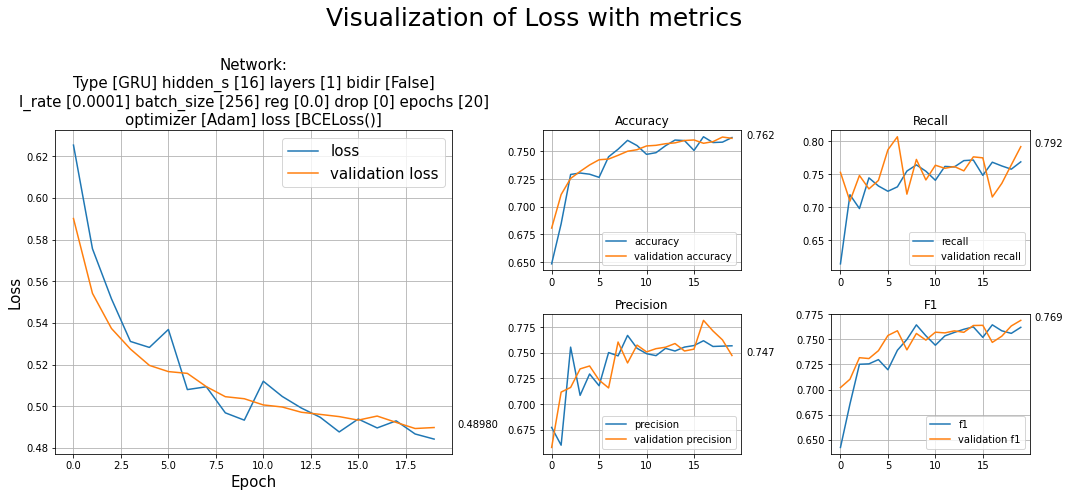

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "GRU"
        self.hidden_size     = 16
        self.num_layers      = 1
        self.bidirectional   = False
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

##### Stacked Layers 2

Total time: 884.8380875587463 time per epoch: 44.24190437793732


<Figure size 432x288 with 0 Axes>

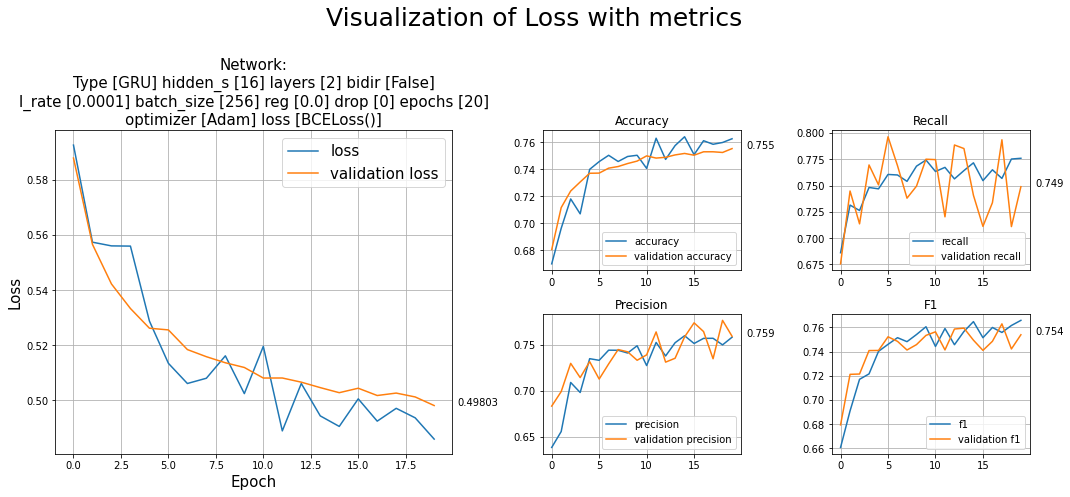

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "GRU"
        self.hidden_size     = 16
        self.num_layers      = 2
        self.bidirectional   = False
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

#### Hidden Layer Size 32


GRU with 32 hidden layers archives a bit grater scores but with 2 stacked layers overfitting start to appear

##### Stacked Layers 1

Total time: 742.5885376930237 time per epoch: 37.12942688465118


<Figure size 432x288 with 0 Axes>

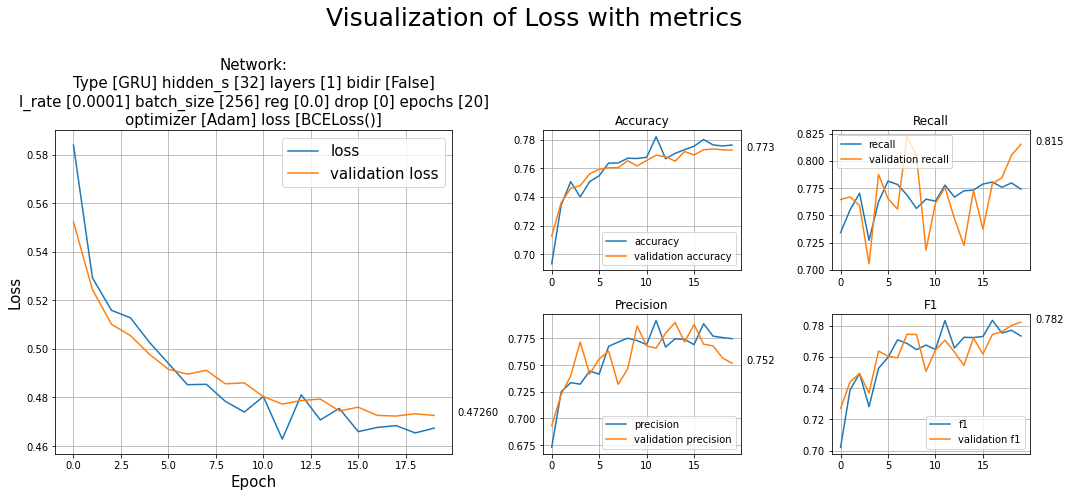

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "GRU"
        self.hidden_size     = 32
        self.num_layers      = 1
        self.bidirectional   = False
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

##### Stacked Layers 2

Total time: 880.5026466846466 time per epoch: 44.02513233423233


<Figure size 432x288 with 0 Axes>

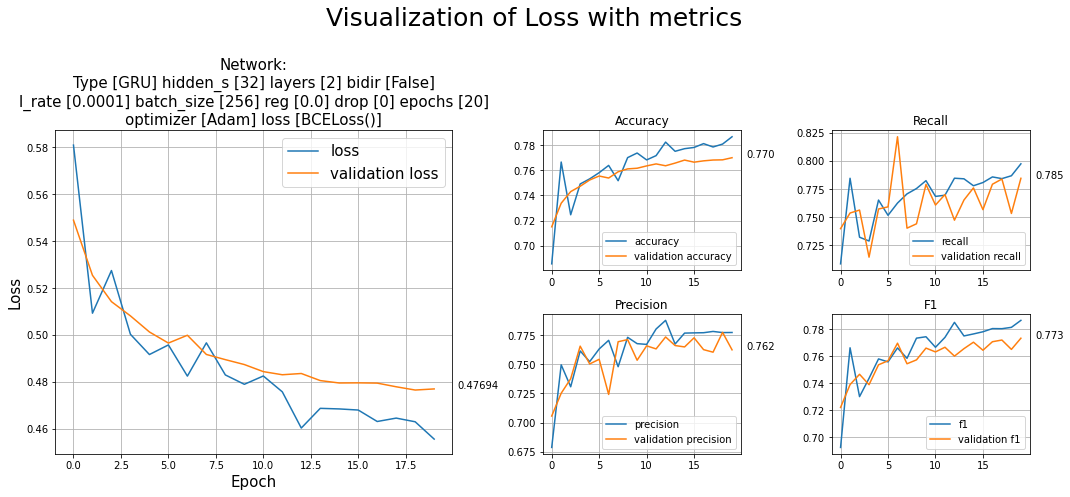

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "GRU"
        self.hidden_size     = 32
        self.num_layers      = 2
        self.bidirectional   = False
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

#### Hidden Layer Size 64


64 layers can transfer more information from 32, however that comes with a cost and overfitting is more significant to 32 layers. 

##### Stacked Layers 1

Total time: 731.9263417720795 time per epoch: 36.596317088603975


<Figure size 432x288 with 0 Axes>

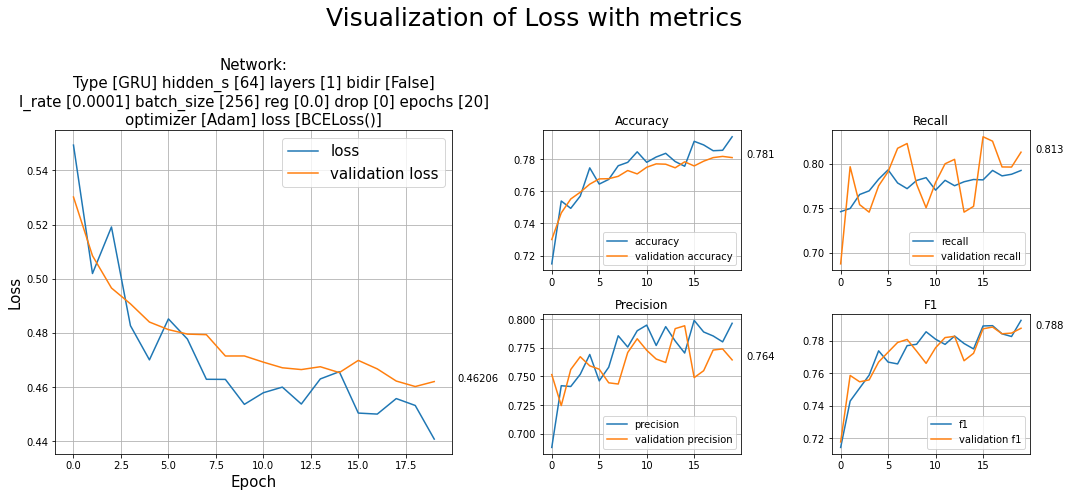

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "GRU"
        self.hidden_size     = 64
        self.num_layers      = 1
        self.bidirectional   = False
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

##### Stacked Layers 2

Total time: 903.1852686405182 time per epoch: 45.15926343202591


<Figure size 432x288 with 0 Axes>

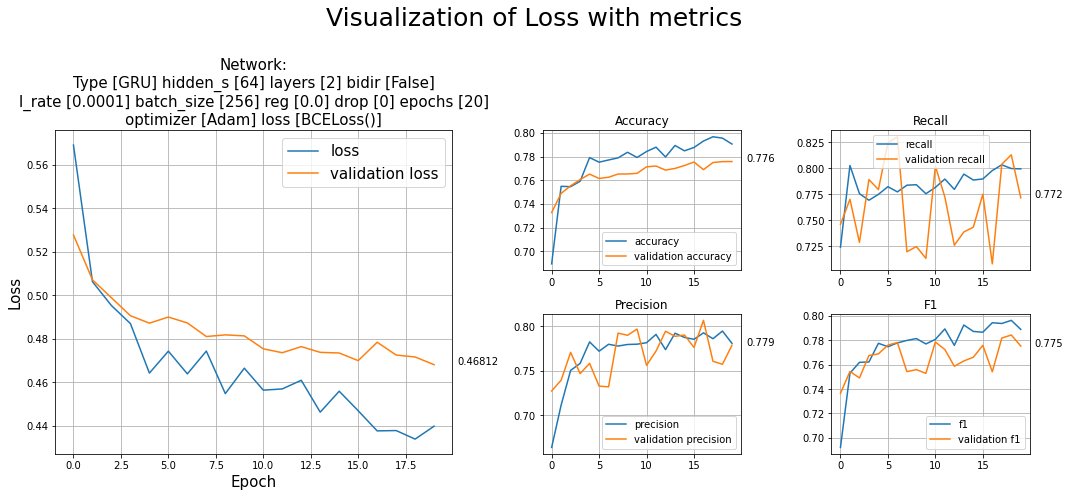

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "GRU"
        self.hidden_size     = 64
        self.num_layers      = 2
        self.bidirectional   = False
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

#### Hidden Layer Size 256

With 256 layers overfitting is such a problem that due to that poor generalization the accuracy score starts to decrease.

Total time: 1187.3907475471497 time per epoch: 59.36953737735748


<Figure size 432x288 with 0 Axes>

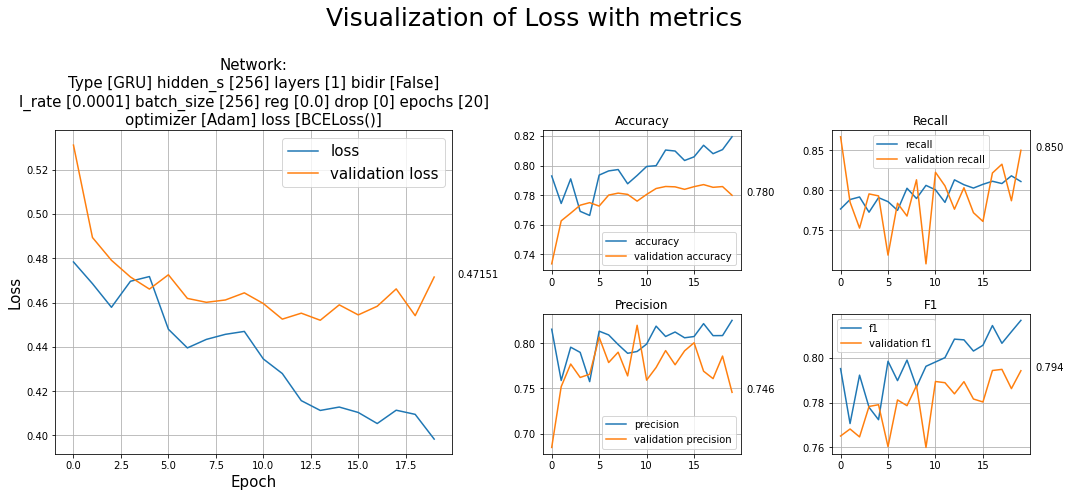

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "GRU"
        self.hidden_size     = 256
        self.num_layers      = 1
        self.bidirectional   = False
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

### Bidirectional

#### Hidden Layer Size 16

Bidirectionality at a small hidden layer size has little effect. The extra rnn block that passes the sequence backward doesn't add up much to this dataset.

##### Stacked Layers 1

Total time: 1014.4598033428192 time per epoch: 50.72299016714096


<Figure size 432x288 with 0 Axes>

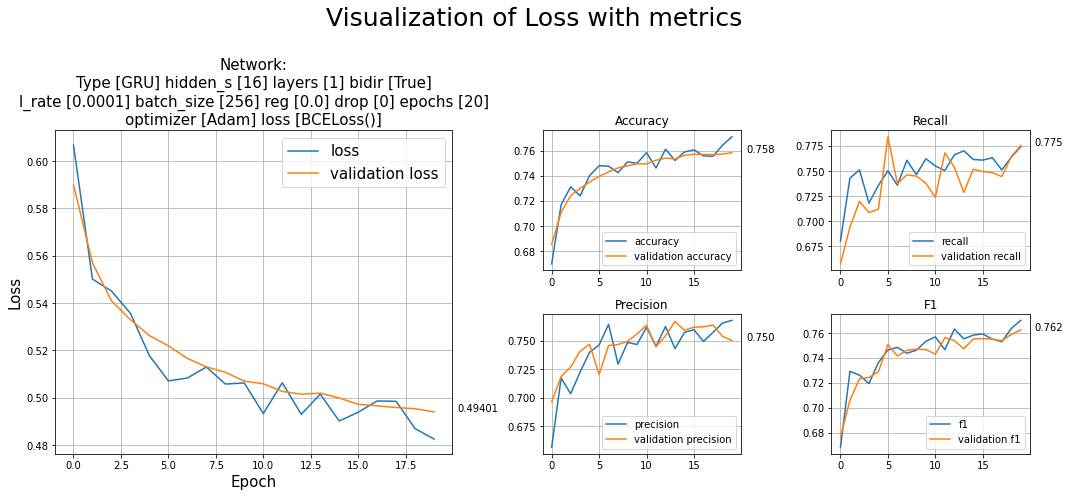

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "GRU"
        self.hidden_size     = 16
        self.num_layers      = 1
        self.bidirectional   = True
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

##### Stacked Layers 2

Total time: 1452.0900301933289 time per epoch: 72.60450150966645


<Figure size 432x288 with 0 Axes>

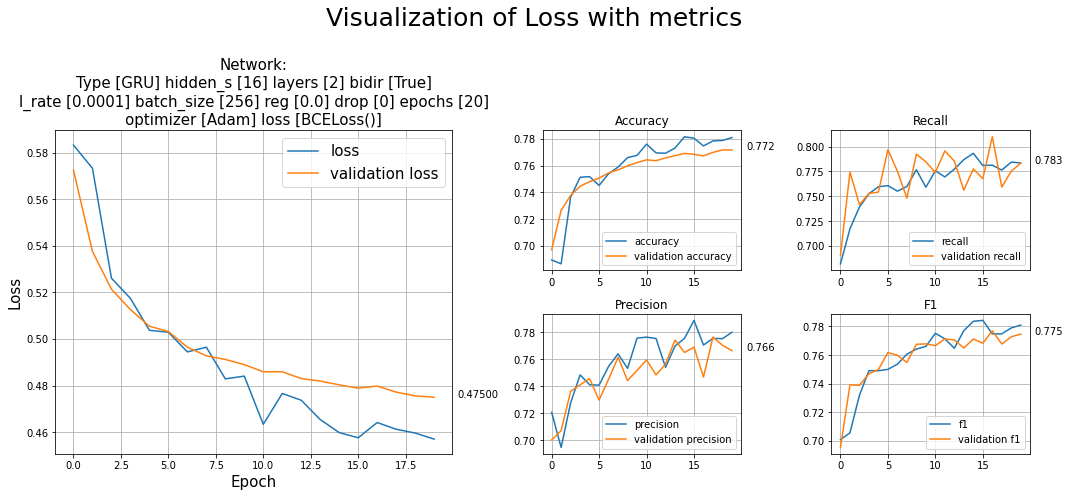

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "GRU"
        self.hidden_size     = 16
        self.num_layers      = 2
        self.bidirectional   = True
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

#### Hidden Layer Size 32

32 hidden layers have better performance than the 32 however there is more overfitting which we will try to reduce with dropout

##### Stacked Layers 1

Total time: 932.9831387996674 time per epoch: 46.64915693998337


<Figure size 432x288 with 0 Axes>

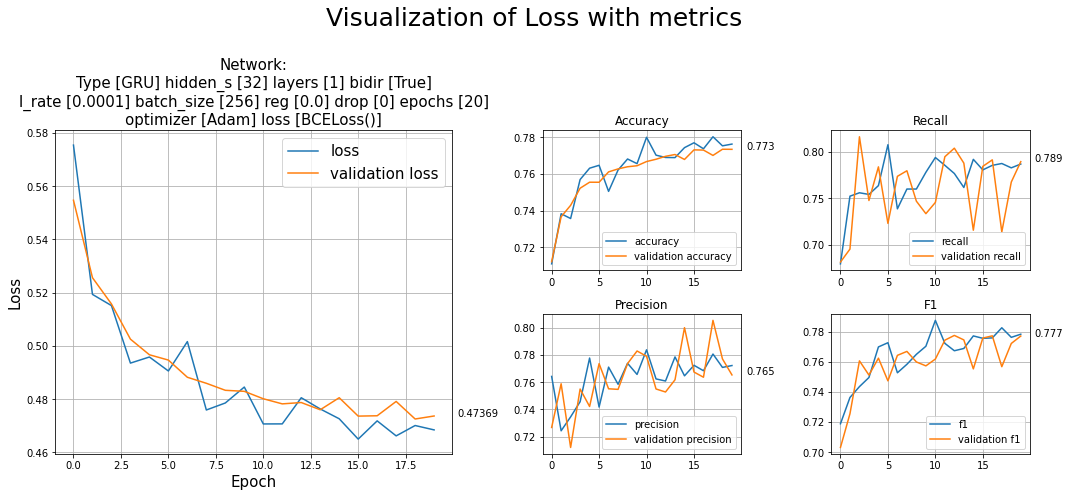

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "GRU"
        self.hidden_size     = 32
        self.num_layers      = 1
        self.bidirectional   = True
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

##### Stacked Layers 2

Total time: 1456.2505989074707 time per epoch: 72.81252994537354


<Figure size 432x288 with 0 Axes>

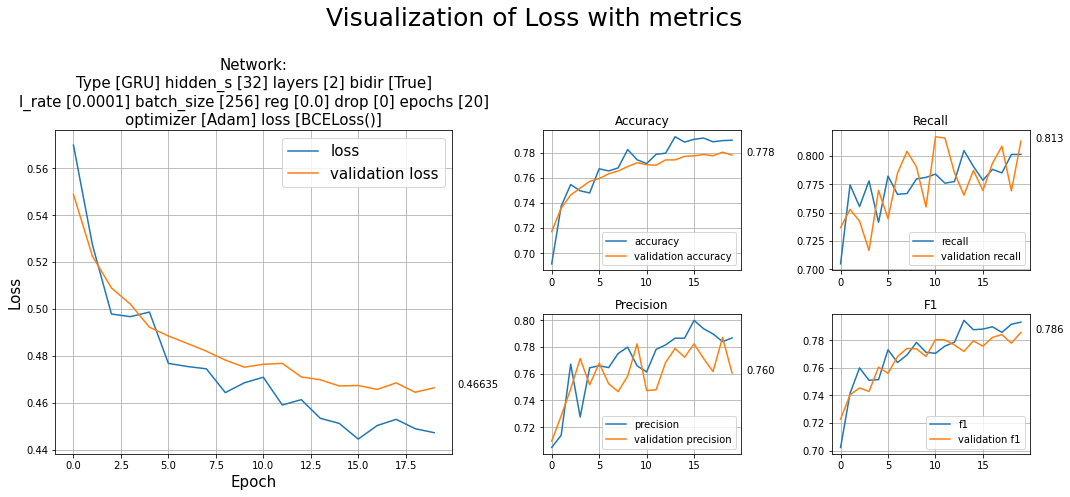

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "GRU"
        self.hidden_size     = 32
        self.num_layers      = 2
        self.bidirectional   = True
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

###### Dropout

Dropout reduces overfitting but does increase the accuracy, although it equalizes the other metrics.

Total time: 1560.9287269115448 time per epoch: 78.04643634557723


<Figure size 432x288 with 0 Axes>

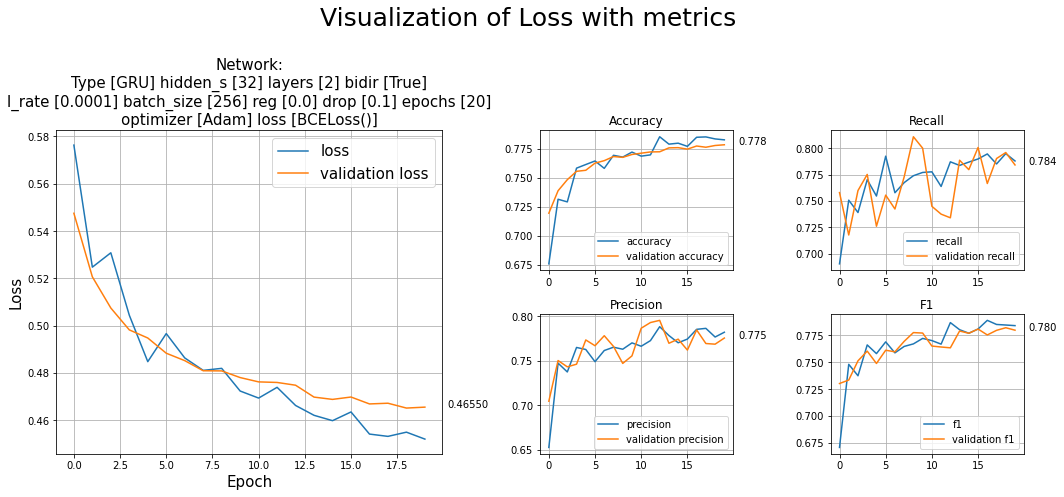

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "GRU"
        self.hidden_size     = 32
        self.num_layers      = 2
        self.bidirectional   = True
        self.dropout         = 0.1
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

Total time: 1575.9409108161926 time per epoch: 78.79704554080963


<Figure size 432x288 with 0 Axes>

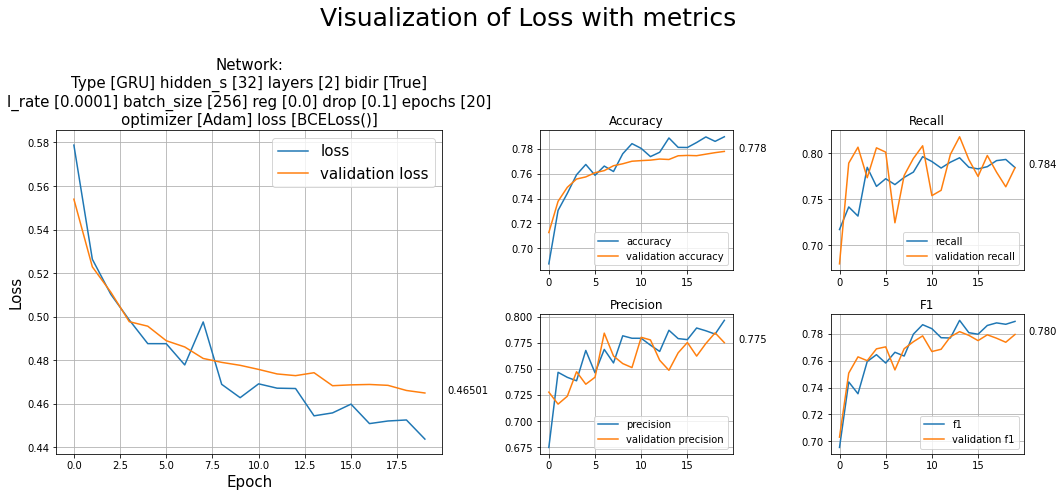

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "GRU"
        self.hidden_size     = 32
        self.num_layers      = 2
        self.bidirectional   = True
        self.dropout         = 0.1
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

#### Hidden Size 64

64 bidirectional layers are the same as unidirectional.

##### Stacked Layers 1

Total time: 966.0487749576569 time per epoch: 48.302438747882846


<Figure size 432x288 with 0 Axes>

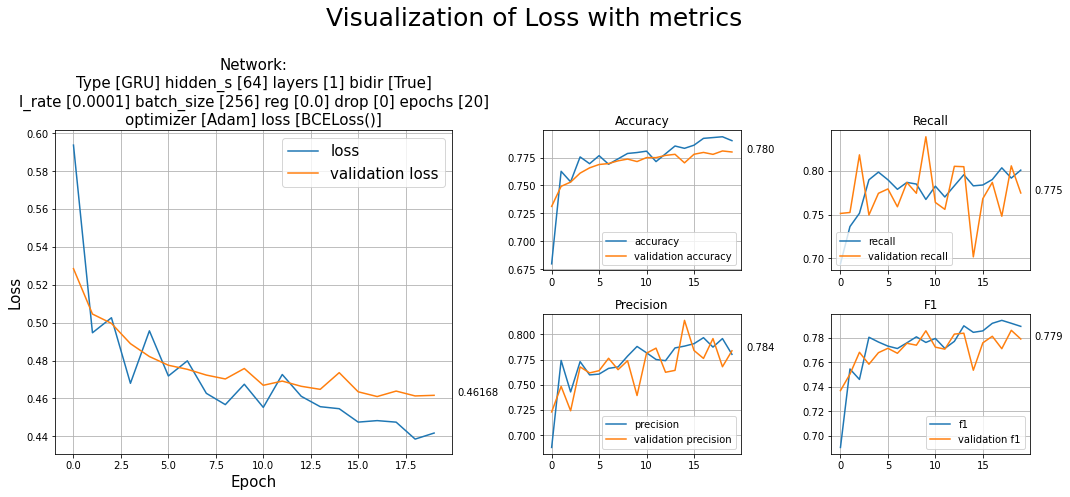

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "GRU"
        self.hidden_size     = 64
        self.num_layers      = 1
        self.bidirectional   = True
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

#### Hidden Size 256


256 layers in a bidirectional GRU block stores a lot of information, that's why this model overfitted so badly. Even with a 0.5 dropout, the overfitting couldn't be reduced.

##### Stacked Layers 1

Total time: 1957.2276320457458 time per epoch: 97.8613816022873


<Figure size 432x288 with 0 Axes>

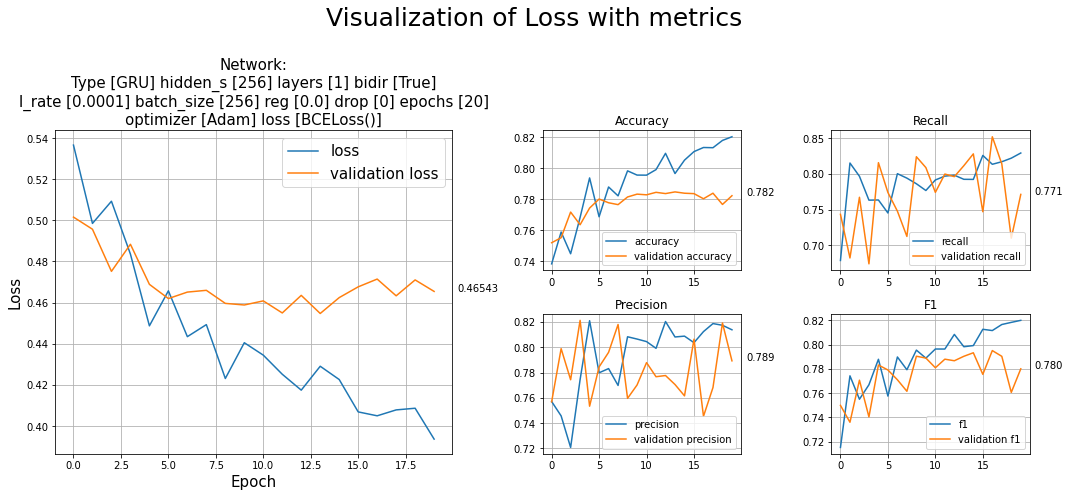

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "GRU"
        self.hidden_size     = 256
        self.num_layers      = 1
        self.bidirectional   = True
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

###### Dropout

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Total time: 1963.0565617084503 time per epoch: 98.15282808542251


<Figure size 432x288 with 0 Axes>

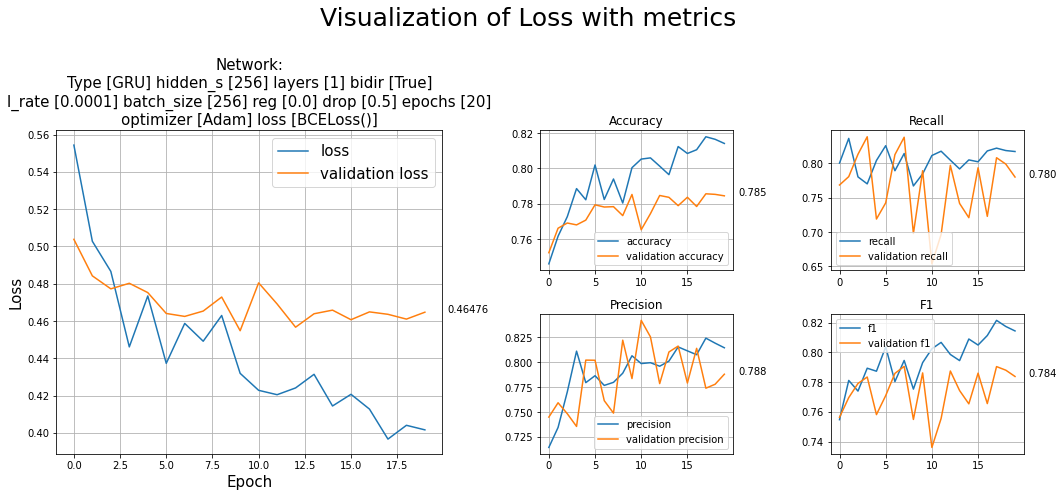

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "GRU"
        self.hidden_size     = 256
        self.num_layers      = 1
        self.bidirectional   = True
        self.dropout         = 0.5
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

## LSTM

The LSTM cell adds more gates for the hidden layers thus the model can learn to optimize better for long sentences and which context is spread in different parts.

However in practice there is no significant improvement over the simpler GRU cells

### Unidirectional

#### Hidden Size 16

16 layers offer a good overall performance with no overfitting even with 2 layers

##### Stacked Layers 1

Total time: 718.6831486225128 time per epoch: 35.93415743112564


<Figure size 432x288 with 0 Axes>

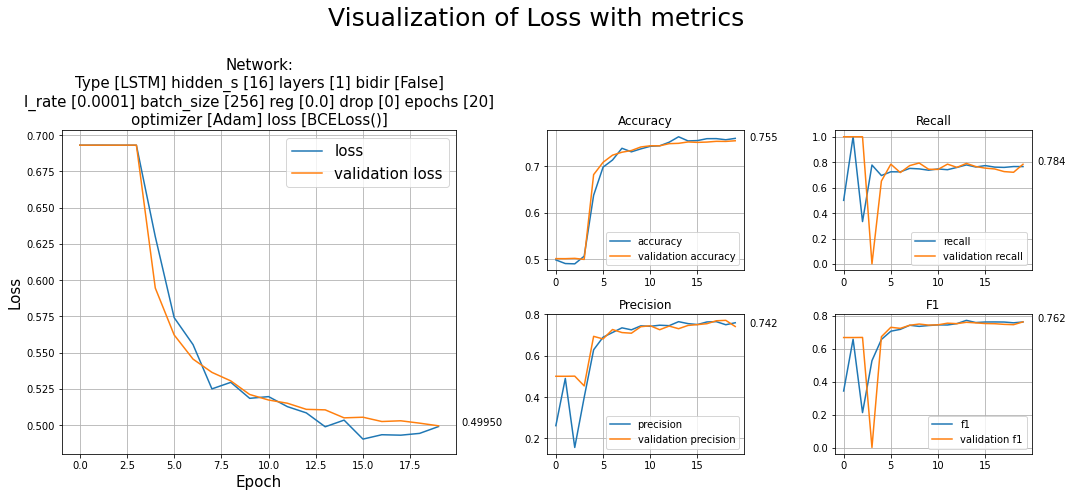

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 16
        self.num_layers      = 1
        self.bidirectional   = False
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

##### Stacked Layers 2

Total time: 954.5746645927429 time per epoch: 47.72873322963714


<Figure size 432x288 with 0 Axes>

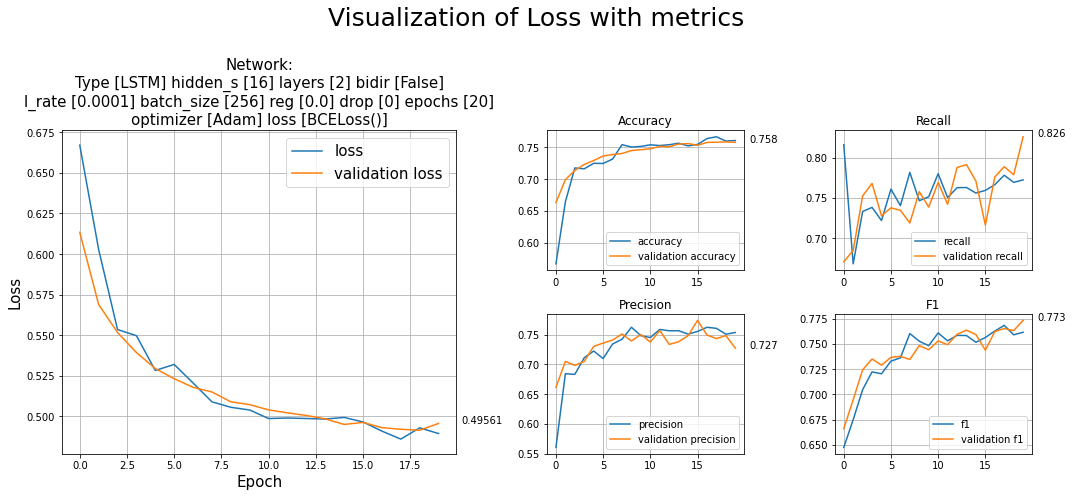

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 16
        self.num_layers      = 2
        self.bidirectional   = False
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

Total time: 1810.763326883316 time per epoch: 45.2690831720829


<Figure size 432x288 with 0 Axes>

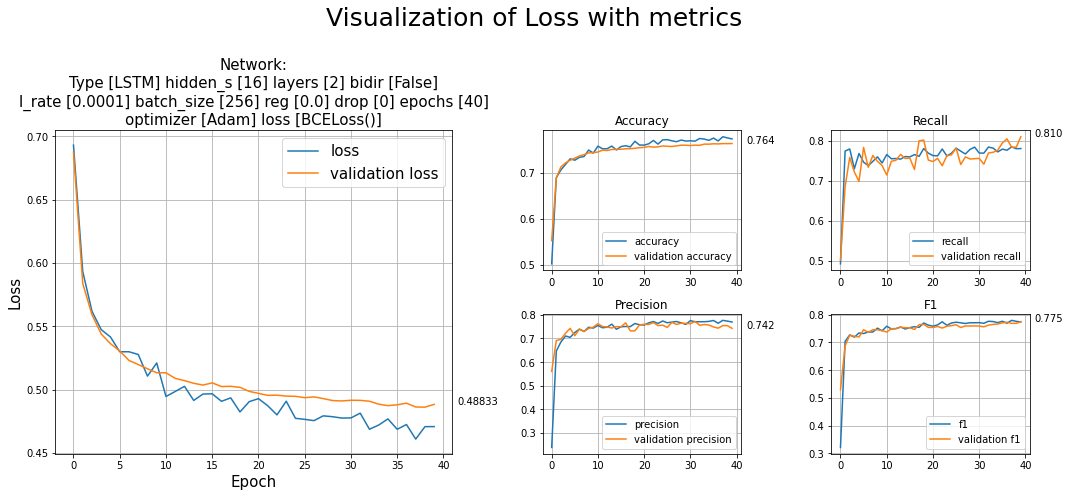

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 16
        self.num_layers      = 2
        self.bidirectional   = False
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 40

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

#### Hidden Size 32

32 hidden layers have slight better performance also with little overfiting even with 2 stacked layers

##### Stacked Layers 1

Total time: 744.6016964912415 time per epoch: 37.23008482456207


<Figure size 432x288 with 0 Axes>

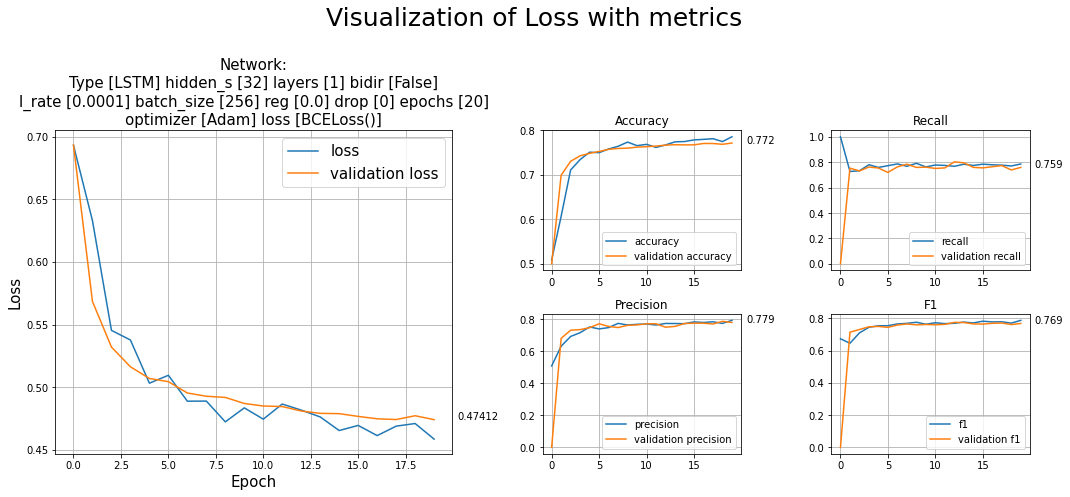

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 32
        self.num_layers      = 1
        self.bidirectional   = False
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

##### Stacked Layers 2

Total time: 890.7038526535034 time per epoch: 44.53519263267517


<Figure size 432x288 with 0 Axes>

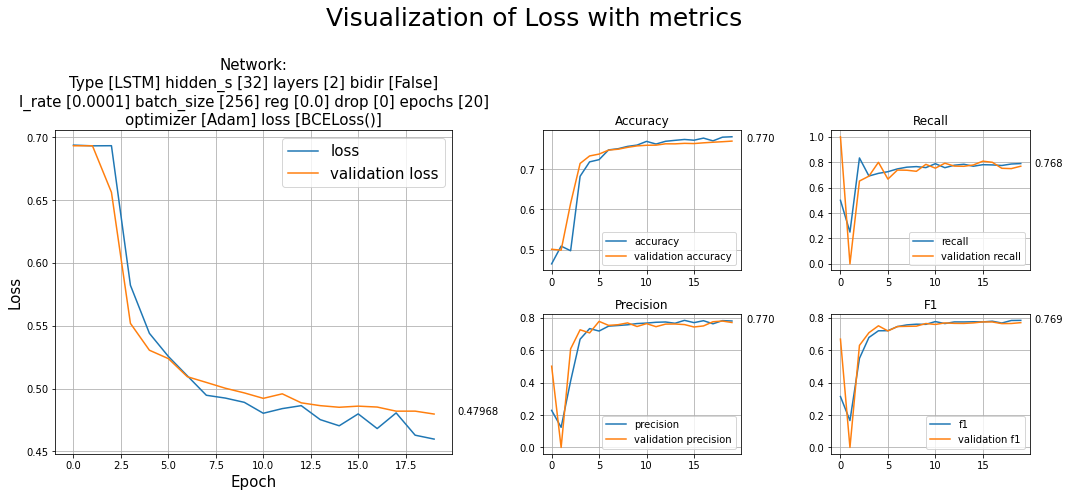

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 32
        self.num_layers      = 2
        self.bidirectional   = False
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

#### Hidden Size 64

64 layers have even better performance but the overfitting is more significant

##### Stacked Layers 1

Total time: 766.1983156204224 time per epoch: 38.30991578102112


<Figure size 432x288 with 0 Axes>

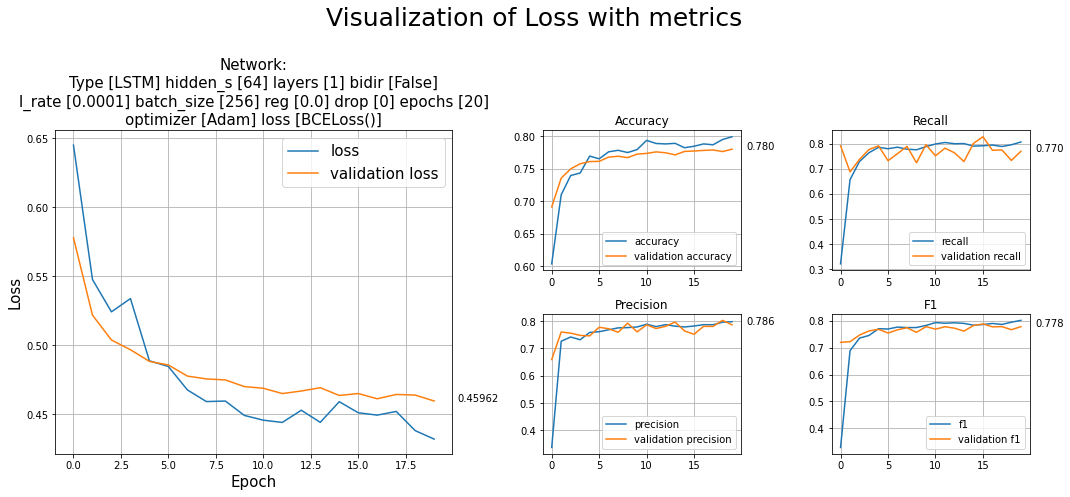

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 64
        self.num_layers      = 1
        self.bidirectional   = False
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

##### Stacked Layers 2

Total time: 928.4026155471802 time per epoch: 46.420130777359006


<Figure size 432x288 with 0 Axes>

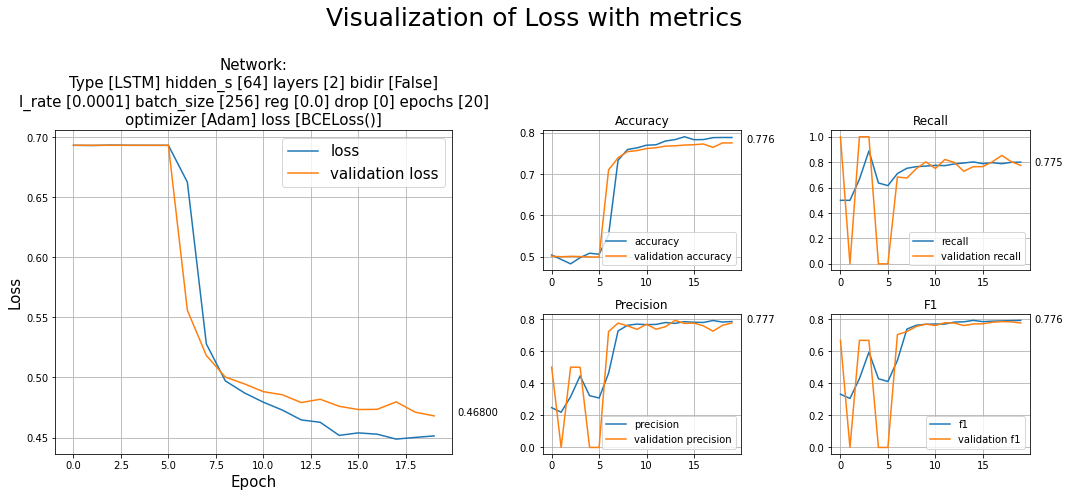

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 64
        self.num_layers      = 2
        self.bidirectional   = False
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

#### Hidden Size 128

128 layers are the most interesting.

They take longer to optimize because there more parameters but when they are trained they are overfitting more than the other layers.

So that early stopping at 20 epochs is required

##### Stacked Layers 1

Total time: 834.6235699653625 time per epoch: 41.73117849826813


<Figure size 432x288 with 0 Axes>

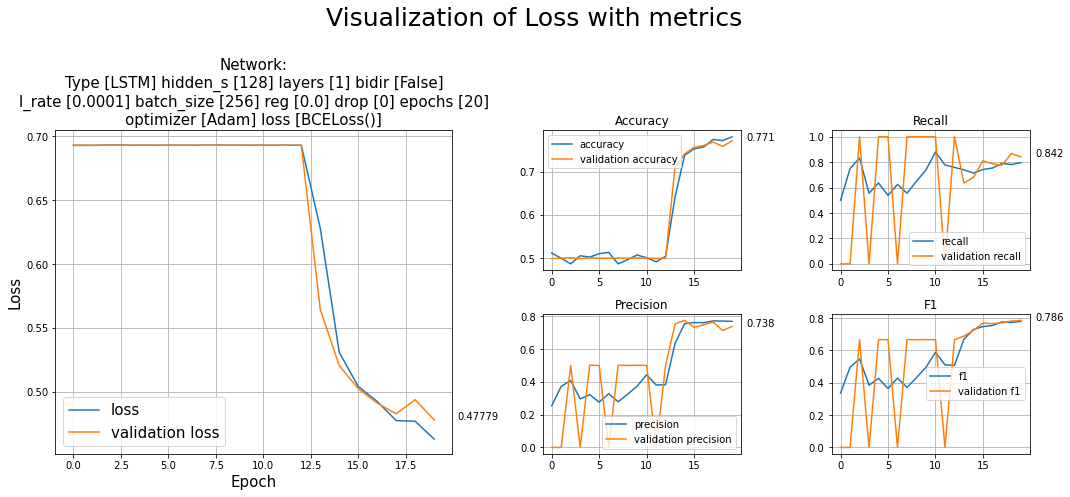

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 128
        self.num_layers      = 1
        self.bidirectional   = False
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

##### Stacked Layers 2

Total time: 1157.5685217380524 time per epoch: 57.87842608690262


<Figure size 432x288 with 0 Axes>

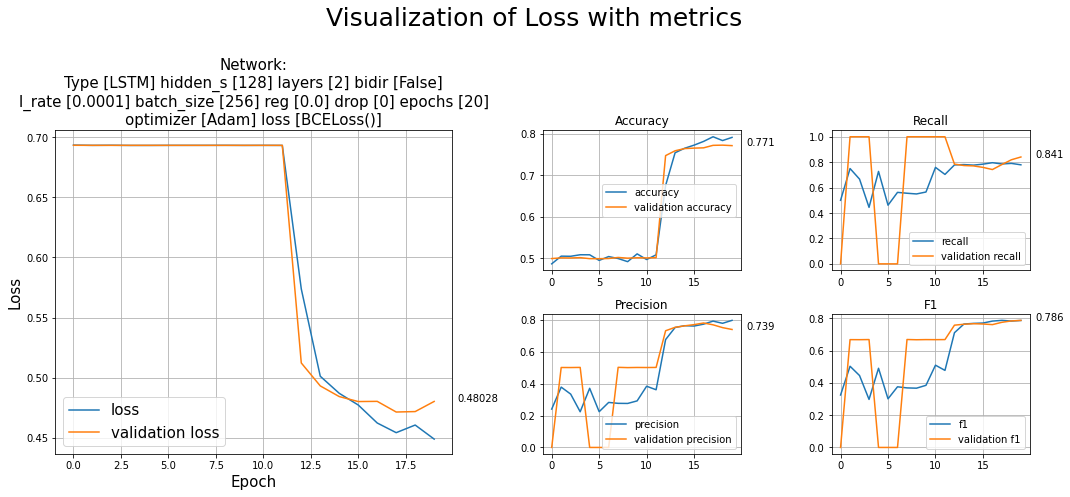

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 128
        self.num_layers      = 2
        self.bidirectional   = False
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

### Bidirectional

Bidirectional lstm offers the inforamtion for the future words maybe can get better scores.

#### Hidden Size 16

16 layers are the same with the unidirectional lstm

However if they are trained with a lot of epochs they also tend to overfitt

##### Stacked Layers 1

Total time: 1025.9052879810333 time per epoch: 51.29526439905167


<Figure size 432x288 with 0 Axes>

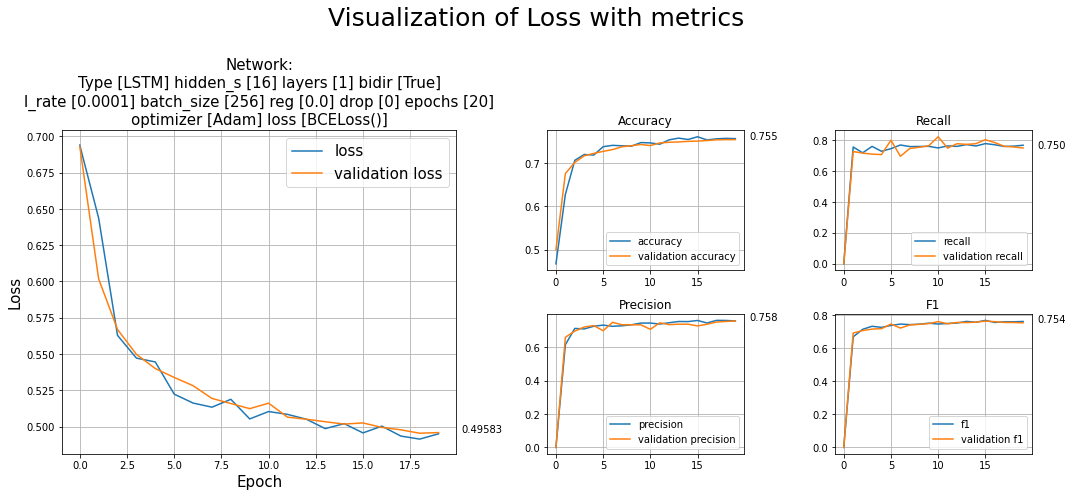

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 16
        self.num_layers      = 1
        self.bidirectional   = True
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

Total time: 1820.2145502567291 time per epoch: 45.50536375641823


<Figure size 432x288 with 0 Axes>

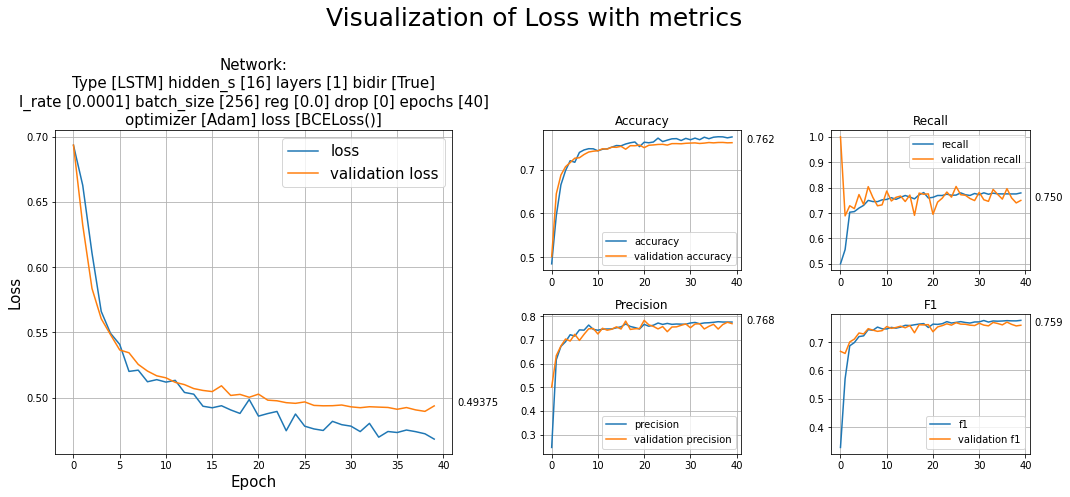

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 16
        self.num_layers      = 1
        self.bidirectional   = True
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 40

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

##### Stacked Layers 2

Total time: 1481.1950106620789 time per epoch: 74.05975053310394


<Figure size 432x288 with 0 Axes>

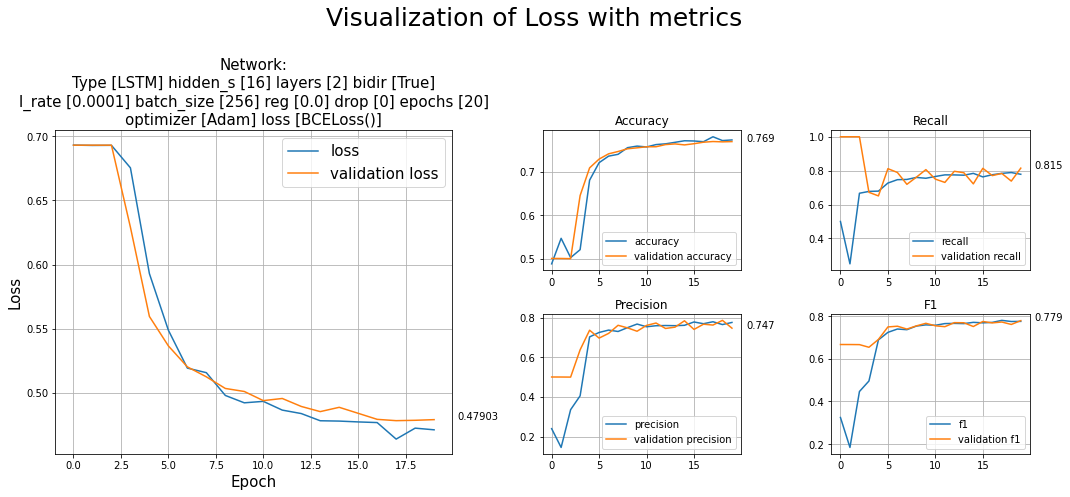

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 16
        self.num_layers      = 2
        self.bidirectional   = True
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

#### Hidden Size 32

32 layers have a better performance than 16 but also we will try to introduce gradietn clipping and dropout

##### Stacked Layers 1

Total time: 945.0564651489258 time per epoch: 47.25282325744629


<Figure size 432x288 with 0 Axes>

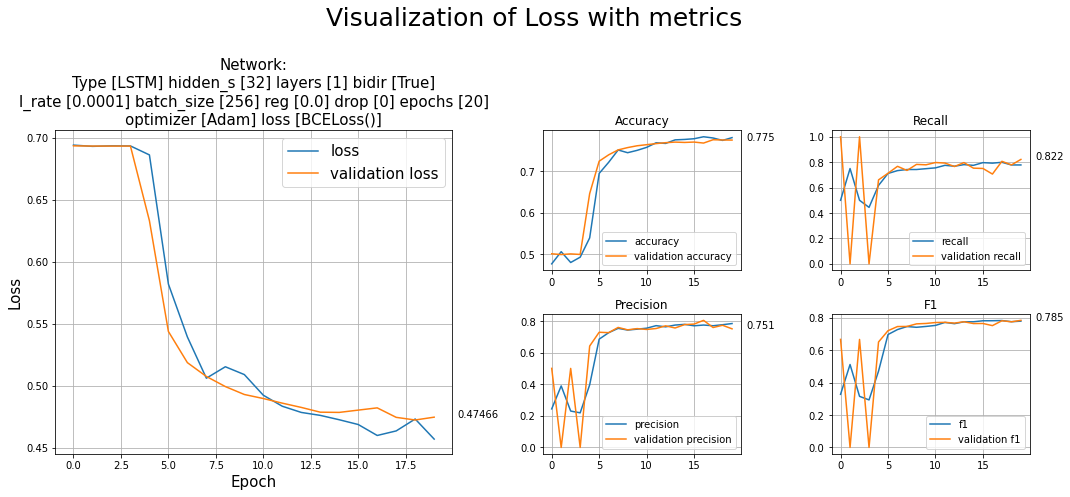

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 32
        self.num_layers      = 1
        self.bidirectional   = True
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

###### Gradient Clipping

All the test are set with gradient clipping at 1.

Setting it lower to 0.5 won't have a significant change.

Even setting it to 10 means that gradient clipping won't practically kick in to clip the gradients won't change the results.

One last observation is that gradient clipping has a slight regularization effect.

Total time: 1004.3184514045715 time per epoch: 50.21592257022858


<Figure size 432x288 with 0 Axes>

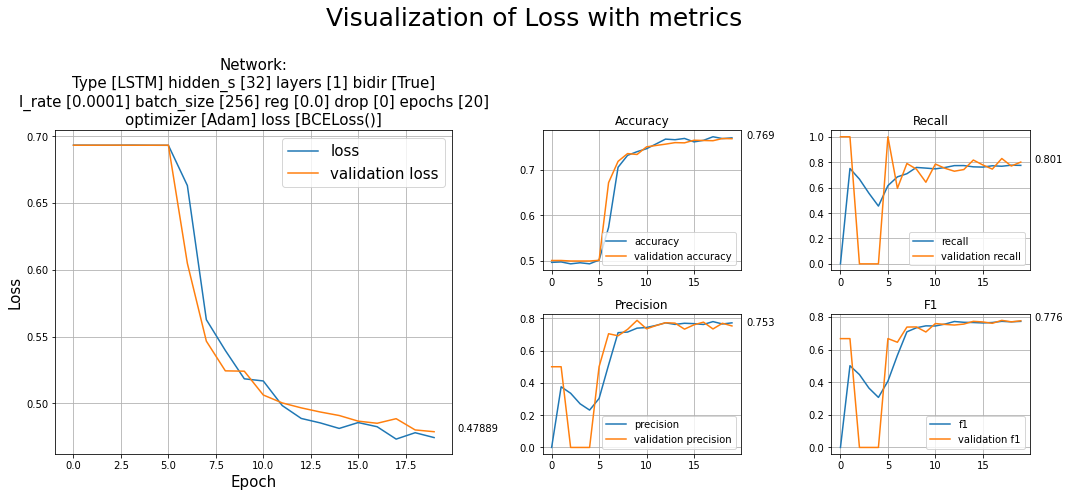

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 32
        self.num_layers      = 1
        self.bidirectional   = True
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 0.5
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

Total time: 1001.4943051338196 time per epoch: 50.07471525669098


<Figure size 432x288 with 0 Axes>

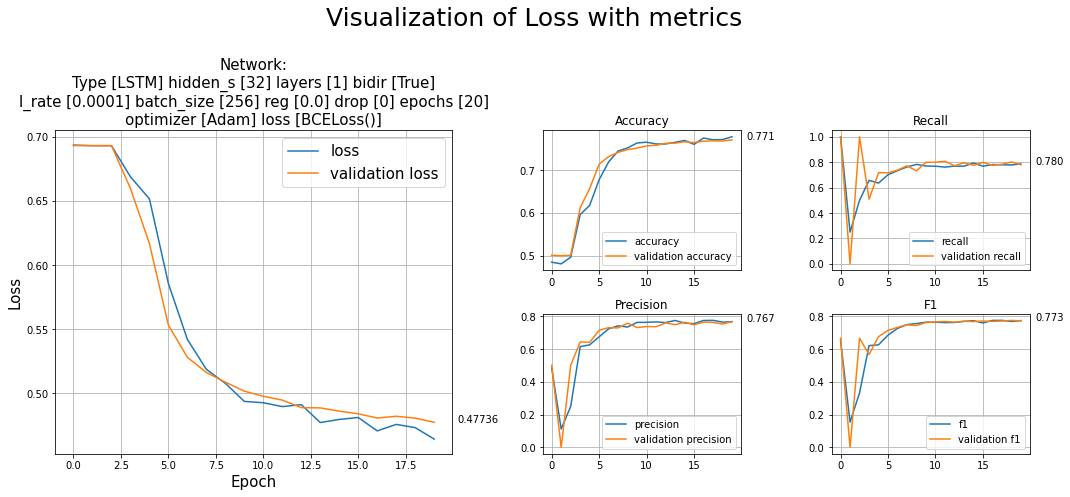

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 32
        self.num_layers      = 1
        self.bidirectional   = True
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 10
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

##### Stacked Layers 2

Total time: 1458.77321434021 time per epoch: 72.93866071701049


<Figure size 432x288 with 0 Axes>

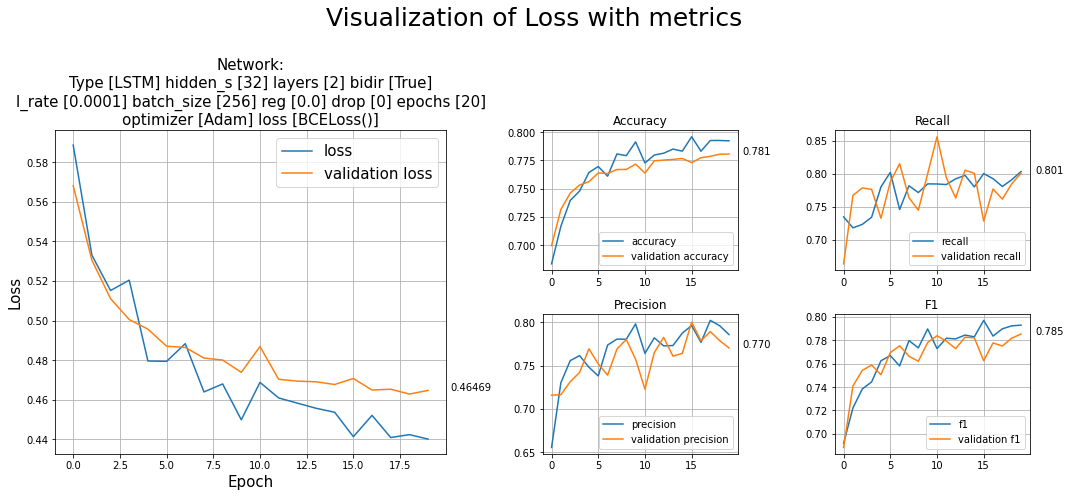

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 32
        self.num_layers      = 2
        self.bidirectional   = True
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

2 bidirectional layers are overfitting thus we will try to regularize with dropout

###### Dropout

0.5 and 0.2 dropout rates are too high that the model underfits and is not converging

0.05 rate is small but it reduces overfitting

Total time: 1557.753525018692 time per epoch: 77.8876762509346


<Figure size 432x288 with 0 Axes>

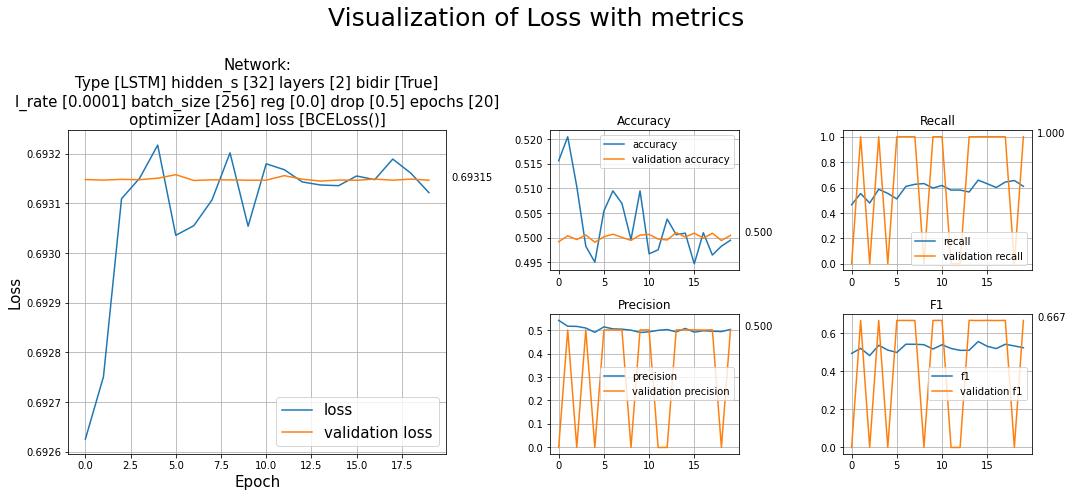

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 32
        self.num_layers      = 2
        self.bidirectional   = True
        self.dropout         = 0.5
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

Total time: 1589.9138119220734 time per epoch: 79.49569059610367


<Figure size 432x288 with 0 Axes>

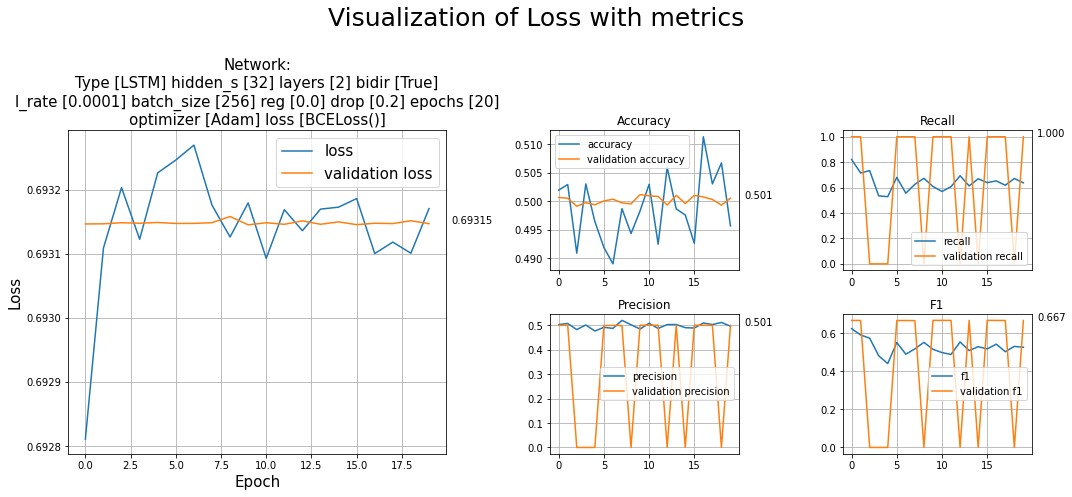

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 32
        self.num_layers      = 2
        self.bidirectional   = True
        self.dropout         = 0.2
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

Total time: 1623.0440881252289 time per epoch: 81.15220440626145


<Figure size 432x288 with 0 Axes>

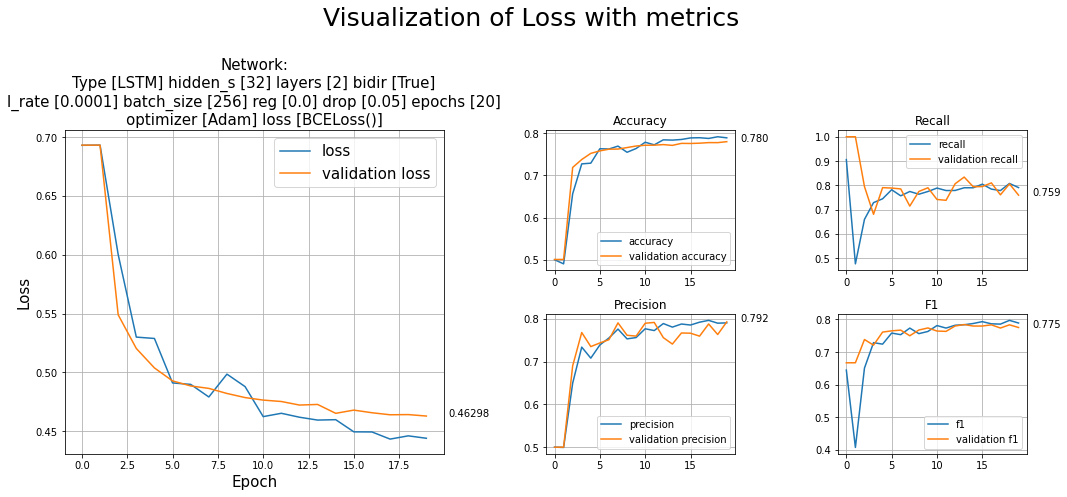

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 32
        self.num_layers      = 2
        self.bidirectional   = True
        self.dropout         = 0.05
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

#### Hidden Size 64

64 hidden layers are as all the other rnn configurations run better than the 32 layers however they are overfittng even with one stacked layer.

##### Stacked Layers 1

Total time: 1062.858247756958 time per epoch: 53.1429123878479


<Figure size 432x288 with 0 Axes>

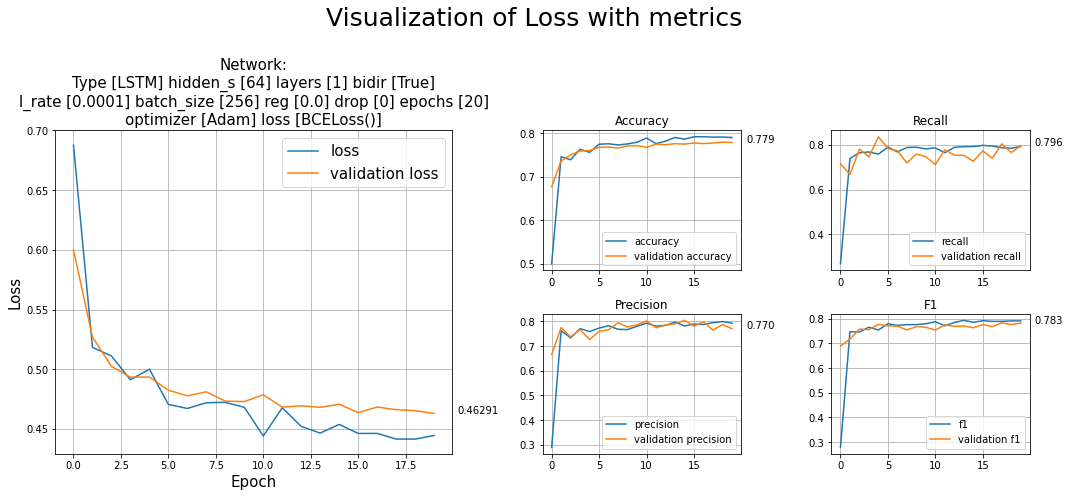

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 64
        self.num_layers      = 1
        self.bidirectional   = True
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

###### Dropout

0.5 dropout rate is a very high rate and model wont converge

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Total time: 1029.548991203308 time per epoch: 51.477449560165404


<Figure size 432x288 with 0 Axes>

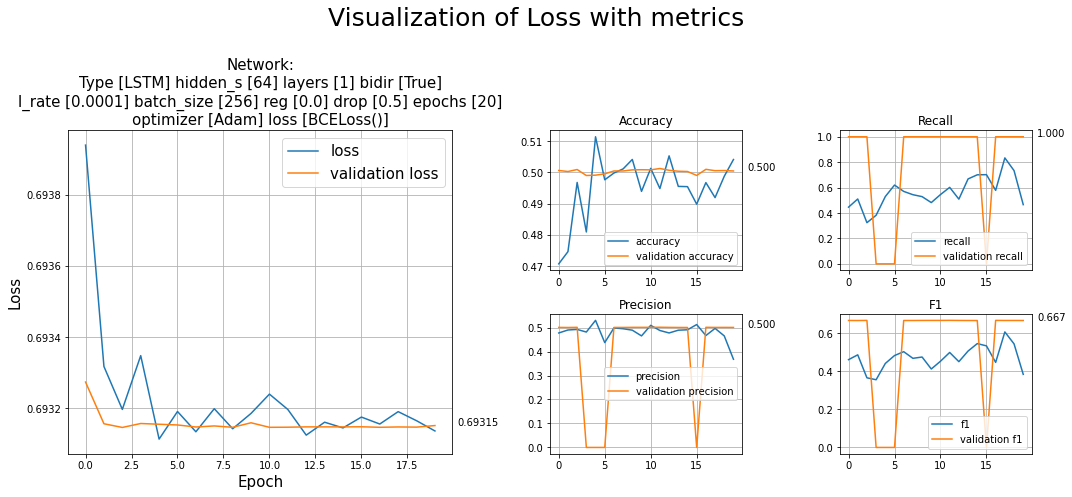

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 64
        self.num_layers      = 1
        self.bidirectional   = True
        self.dropout         = 0.5
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

##### Stacked Layers 2

Total time: 1549.662746667862 time per epoch: 77.4831373333931


<Figure size 432x288 with 0 Axes>

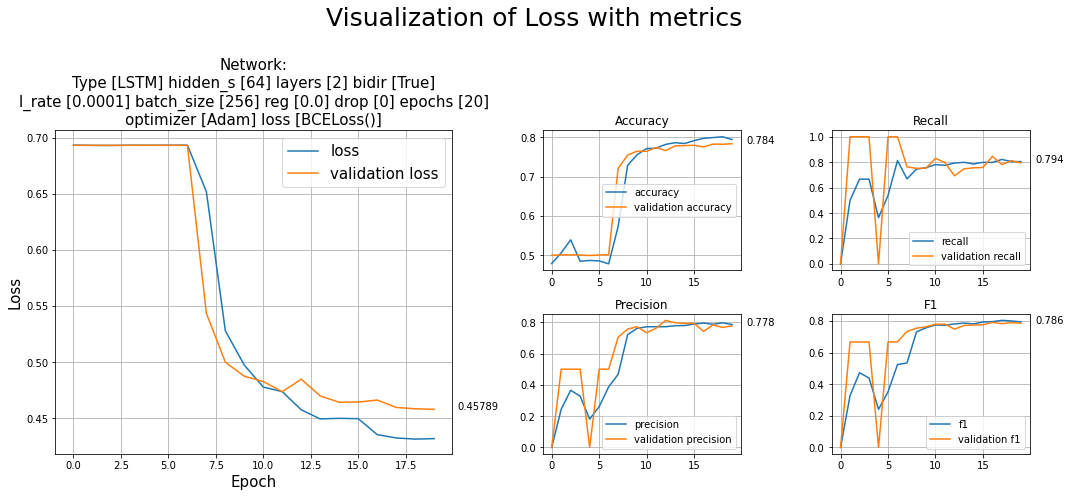

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 64
        self.num_layers      = 2
        self.bidirectional   = True
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

###### Dropout

Total time: 1647.0374405384064 time per epoch: 82.35187202692032


<Figure size 432x288 with 0 Axes>

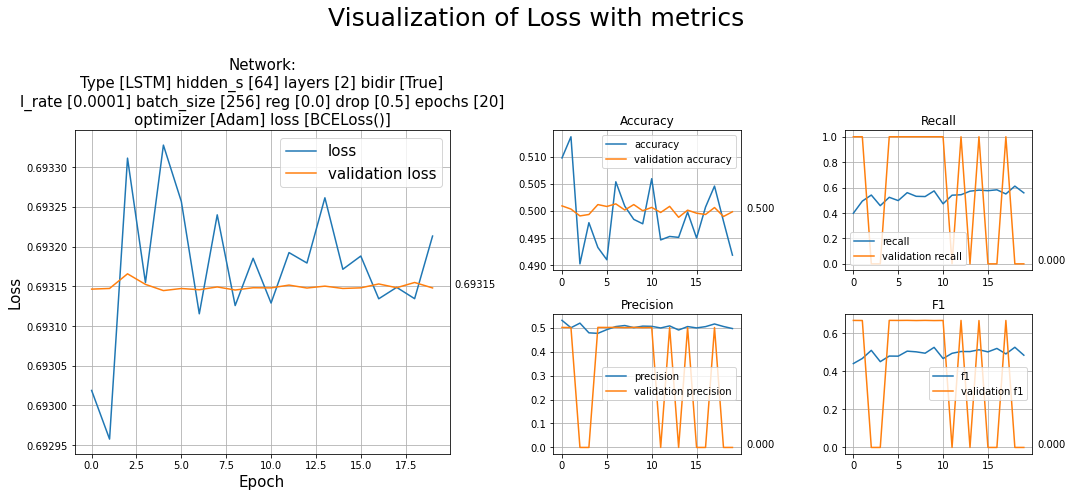

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 64
        self.num_layers      = 2
        self.bidirectional   = True
        self.dropout         = 0.5
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

#### Hidden Size 128

128 hidden layers are overfitting more but the have better results

##### Stacked Layers 1 

Total time: 1338.0081677436829 time per epoch: 66.90040838718414


<Figure size 432x288 with 0 Axes>

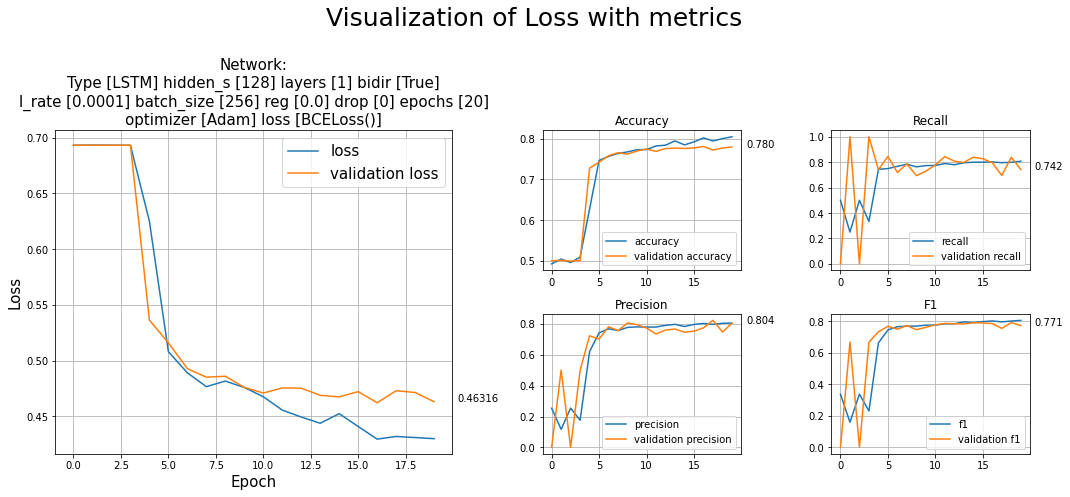

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 128
        self.num_layers      = 1
        self.bidirectional   = True
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

###### Dropout

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Total time: 1331.8847737312317 time per epoch: 66.59423868656158


<Figure size 432x288 with 0 Axes>

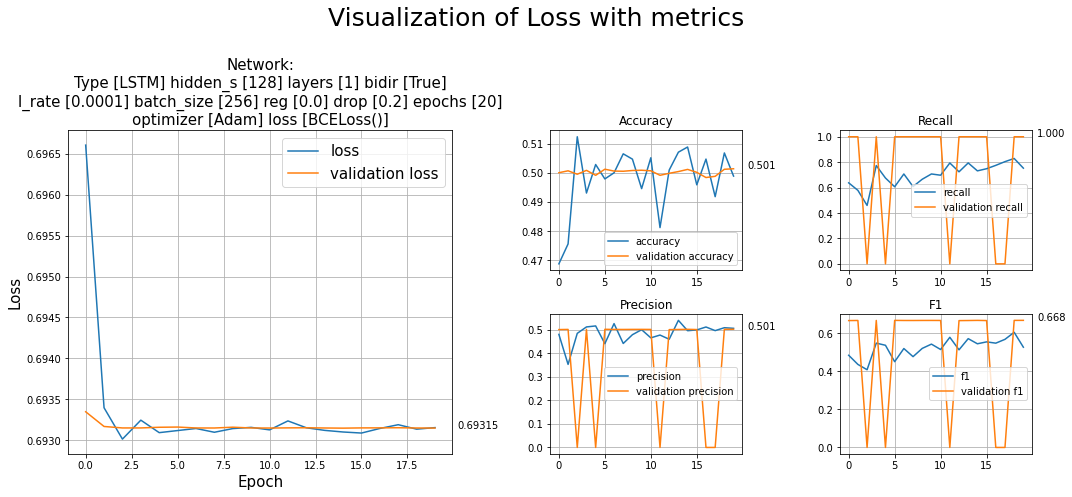

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 128
        self.num_layers      = 1
        self.bidirectional   = True
        self.dropout         = 0.2
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 20

config = Config()


history = train_model(embedding_layer, embeddings_dim, device, config, True)
_ = classifier_loss_visualization([history]) 

# Testing results

From the different parameters and configurations of RNN models, we cannot surpass the 0.78 validation accuracy.

GRU and LSTMS even though lstm blocks have more gates and are more complex in this dataset don't have many differences. We can even say that relatively to gru's computational complexity it is superior.

About the number of hidden layers, small sizes of 16, 32, and 64 have great generalization capabilities. Larger sizes only tend to overfit without increasing the score significantly.

Bidirectionality also doesn't have a great impact but we can see a slight improvement.

Dropout and gradient clipping won't also change drastically the results. Also, dropout needs to be very small otherwise the model won't converge.

Finally, for the best configuration that we will apply a random grid search, we will choose the bidirectional LSTM with 8 to 64 layers.

These are the best model configuration because the results show that these configurations have room for improvement. 

# Random Grid Search



For the best model types and configurations that we have come up with from the previous experiments, we will perform a random grid search to find and fine-tune the last parameters that may increase the generalization potential of the model.

For the grid-search we will be using Weights and Biases which is a tool for logging the metrics of the model. After running multiple configurations, which took a lot of time, this generated the parallel coordinates graph that explains the relation and the role that plays each hyperparameter.

The metric which I will try to maximize is the validation f1 score.

The hyper parametes that will be tested are the hidden sizes, the dropoout rate, the gradient clip and the learning rate.

All the other parameters are the best ones choosen from the previous reserach.

In [ ]:
grid_config = {
    'name' : 'random_search_sweep_full_best_models',
    'method': 'random', #grid, random
    'metric': {'name': 'val_f1','goal': 'maximize'},
    'parameters': {
        'hidden_size':    {"distribution":"categorical",  'values': [8, 16, 24, 32, 48, 64]},
        'dropout':        {"distribution":"categorical",  'values': [0, 0.01, 0.05, 0.1]},
        'gradient_clip':  {"distribution":"categorical",  'values': [0.5, 1, 10]},
        'learning_rate':  {"distribution":"categorical",  'values': [0.0001, 0.0003, 0.0007, 0.001]}
    }
}


# function for grid train 
def grid_train(embedding_layer=embedding_layer, embeddings_dim=embeddings_dim, device=device, last_histories=last_histories):
    class Default_Config(object):
        def __init__(self):
            # model
            self.RNN_type        = "LSTM"  #
            self.hidden_size     = 16  ############## 
            self.num_layers      = 1  #
            self.bidirectional   = True  #
            self.dropout         = 0  ################
    
            # parameters
            self.loss            = nn.BCELoss() #
            self.optimizer       = "Adam" #
            self.learning_rate   = 0.0001 ################
            self.momentum        = 0.9 #
            self.weight_decay    = 0.0 #
            self.gradient_clip   = 1 ################
            self.batch_size      = 256 #
            self.test_batch_size = 2048 #
            self.epochs          = 20 #

    default_config = Default_Config()
    history = train_model(embedding_layer, 300, train_embeddings_dataset, validation_embeddings_dataset, device, default_config, True, None)
    last_histories.append(history)

# grid_search
del last_histories[:]
# get the id for the search to save the parametres ar wandb
sweep_id = wandb.sweep(grid_config, project=project)
print("sweep_id ",sweep_id)
wandb.agent(sweep_id, grid_train)

## Parallel Coordinates graph 

Here is the parallel coordinates graph from the weights and biases 

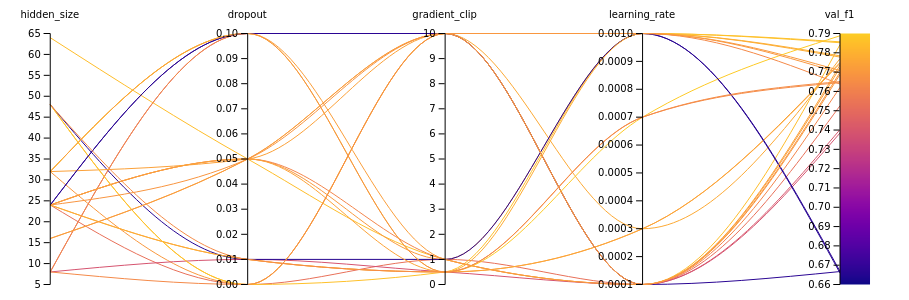

The best configuration has:

Hidden size: **32**

Dropout: **0.1**

Gradient clipping: **0.5**

Learning rate: **0.0007**




We can't find a strong correlation between the parameters that play the most crucial role.

One trend that we can detect is that with hidden layers of less than 16 f1 models perform worse. The best-hidden size should be between 32 and 64.

Another trend is that having a smaller learning rate of 0.0001, models score less in contrast with a greater learning rate of 0.001. The in-between values of the learning rate achieve the best results.

# Attention Model

## Self attention model implementation at pytorch




Below we implement the self attention model proposed by [(Lin et al., 2017)](https://arxiv.org/pdf/1703.03130.pdf)

The parameters of w1 and w2 weights from the Dense layers are 10 and 5 according to the paper.


The use of the self-attention model gives us a context about the location to which the model should pay more attention in the sentence. With this method, the model can activate its neurons more to the areas of the sentence that statistically have shown more contextual importance.

In [ ]:
# a class to create the differnt rnn models
class RNN_Model(torch.nn.Module):

    def __init__(self, RNN_type, embedding_layer, input_size, hidden_size, num_layers, bidirectional=False, dropout=0.1):
        # torch module
        super(RNN_Model, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        if bidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1
        
        # embeddings
        self.embedding = embedding_layer
        self.w1 = 10
        self.w2 = 5
        self.w_class = 1

        # RNN type model
        if RNN_type == "simpleRNN":
            self.rnn = nn.RNN(input_size, hidden_size, num_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        elif RNN_type == "GRU":
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        elif RNN_type == "LSTM":
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        
        # dropout layer
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        
        # linear, tanh, softmax layer
        self.fc1  = nn.Linear(self.hidden_size*self.num_directions*max_sentence_len, self.w1*max_sentence_len)
        self.fc2  = nn.Linear(self.w1*max_sentence_len, self.w2*max_sentence_len)
        self.tanh = nn.Tanh()
        self.soft = nn.Softmax(dim=2)
        self.sig  = nn.Sigmoid()
        
        # dense classifier
        self.flat = nn.Flatten(start_dim=1)
        self.fc_classifier1  = nn.Linear(self.hidden_size*self.num_directions*self.w2, self.w_class)

    def forward(self, x):
        batch_size = x.size(0)
        
        # embeddings and rnn
        embeds = self.embedding(x)
        # print(embeds.size())
        rnn_out, _ = self.rnn(embeds)
        
        # stack up rnn outputs
        seq_len = rnn_out.shape[1] 
        # print(rnn_out.shape)
        rnn_out = rnn_out.contiguous().view(-1, seq_len*self.hidden_size*self.num_directions)
        
        # dropout and fully connected layer 1
        out = self.dropout1(rnn_out)
        out = self.fc1(out)

        # tanh for the attention
        out = self.tanh(out)

        # add the second fully conected layer
        out = self.dropout2(out)
        out = self.fc2(out)

        # reshape to get the w2*seq_len representation for multiple attentions
        out = out.reshape(-1, self.w2, seq_len)

        # softmax function
        attention_out = self.soft(out)
        # print(attention_out.shape)

        # attention_out is a matrix with sefl.w2 * seq_len values
        # each value represents the cotribution of each rnn block
        # now we will multiply these weights to the outputs of each rnn block
        # first we get the H hidden states as batch * seq_len * hidden_size 
        H = rnn_out.reshape(-1, seq_len, self.hidden_size*self.num_directions)
        # print(H.shape)
        attention_hidden_layers = torch.matmul(attention_out, H)
        # print(attention_hidden_layers.shape)

        # flatten for the classification
        attention_hidden_layers_flat = self.flat(attention_hidden_layers)

        # then feed to dense and sigmoid
        classifier_out = self.fc_classifier1(attention_hidden_layers_flat)

        # sigmoid
        classifier_out = self.sig(classifier_out)
        
        # return the sigmoid
        return classifier_out


## Testing of RNN models and parameters with the self-attenntion method to find the best configuration

We will try different configurations on the self attention model

From this simple testing we will not find any better model so we will try the best 

### GRU

With an unidirectional GRU block both 32 and 16 hidden layers do not perform better with the self attention model

#### Hidden Size 16

##### Stacked Layers 1

Total time: 1108.718043088913 time per epoch: 44.348721723556515


<Figure size 432x288 with 0 Axes>

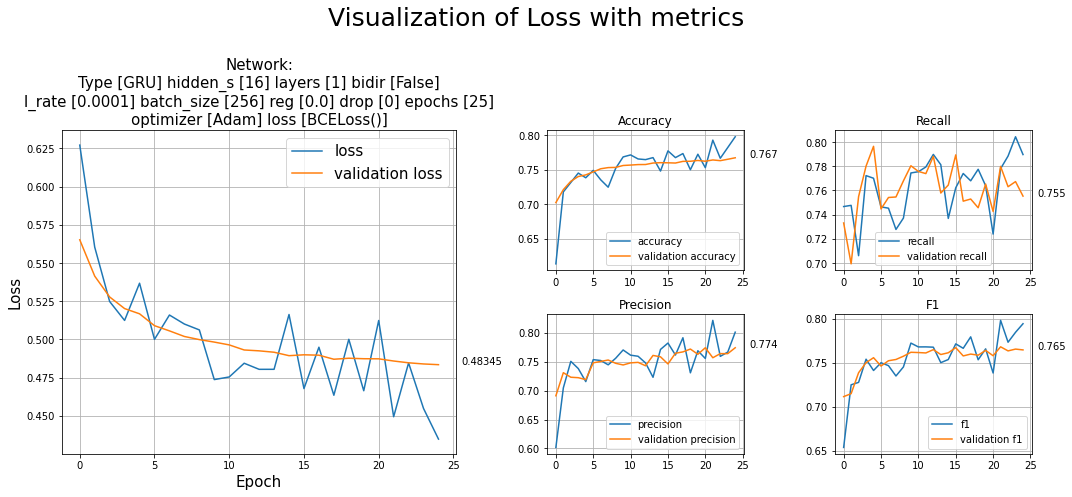

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "GRU"
        self.hidden_size     = 16
        self.num_layers      = 1
        self.bidirectional   = False
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 25

config = Config()


history = train_model(embedding_layer, embeddings_dim, train_embeddings_dataset, validation_embeddings_dataset, device, config, True)
_ = classifier_loss_visualization([history]) 

##### Stacked Layers 2

Total time: 1173.641895532608 time per epoch: 58.6820947766304


<Figure size 432x288 with 0 Axes>

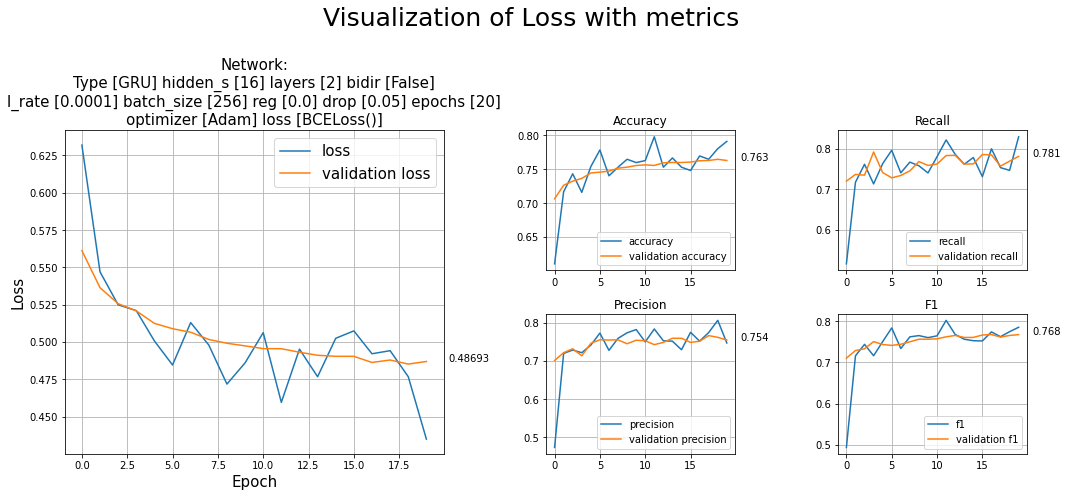

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "GRU"
        self.hidden_size     = 16
        self.num_layers      = 2
        self.bidirectional   = False
        self.dropout         = 0.05
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 25

config = Config()


history = train_model(embedding_layer, embeddings_dim, train_embeddings_dataset, validation_embeddings_dataset, device, config, True)
_ = classifier_loss_visualization([history]) 

#### Hidden Size 32

##### Stacked Layers 1

Total time: 1068.1734375953674 time per epoch: 42.726937503814696


<Figure size 432x288 with 0 Axes>

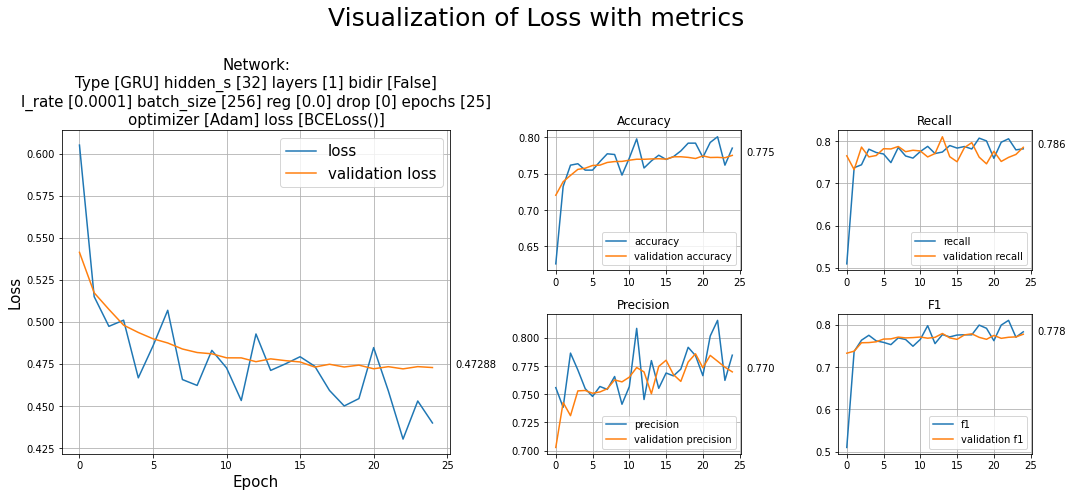

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "GRU"
        self.hidden_size     = 32
        self.num_layers      = 1
        self.bidirectional   = False
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 25

config = Config()


history = train_model(embedding_layer, embeddings_dim, train_embeddings_dataset, validation_embeddings_dataset, device, config, True)
_ = classifier_loss_visualization([history]) 

##### Stacked Layers 2

Total time: 1433.4319107532501 time per epoch: 57.337276430130004


<Figure size 432x288 with 0 Axes>

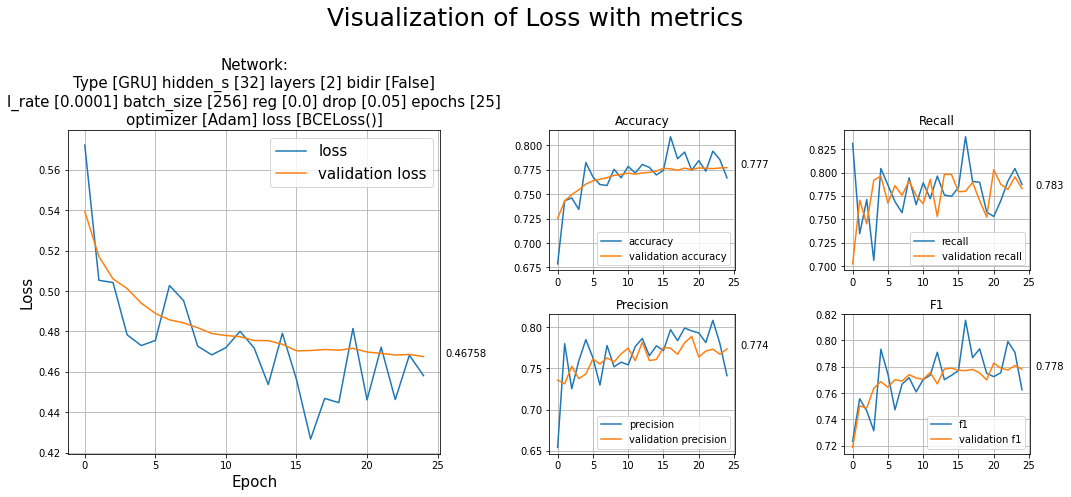

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "GRU"
        self.hidden_size     = 32
        self.num_layers      = 2
        self.bidirectional   = False
        self.dropout         = 0.05
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 25

config = Config()


history = train_model(embedding_layer, embeddings_dim, train_embeddings_dataset, validation_embeddings_dataset, device, config, True)
_ = classifier_loss_visualization([history]) 

### LSTM

We will now test with the better performing hyper-parameters from the previous model

LSTM bidirectional with 32 to 64 layers.

#### Unidirectional

##### Hidden Size 16

Total time: 1072.7946722507477 time per epoch: 42.91178689002991


<Figure size 432x288 with 0 Axes>

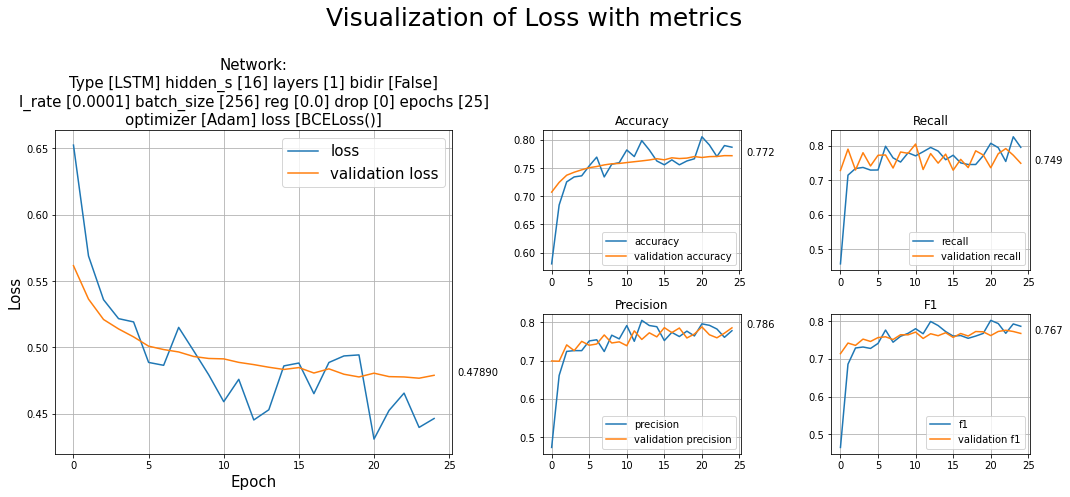

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 16
        self.num_layers      = 1
        self.bidirectional   = False
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 25

config = Config()


history = train_model(embedding_layer, embeddings_dim, train_embeddings_dataset, validation_embeddings_dataset, device, config, True)
_ = classifier_loss_visualization([history]) 

##### Hidden Size 32

Total time: 1084.91690158844 time per epoch: 43.3966760635376


<Figure size 432x288 with 0 Axes>

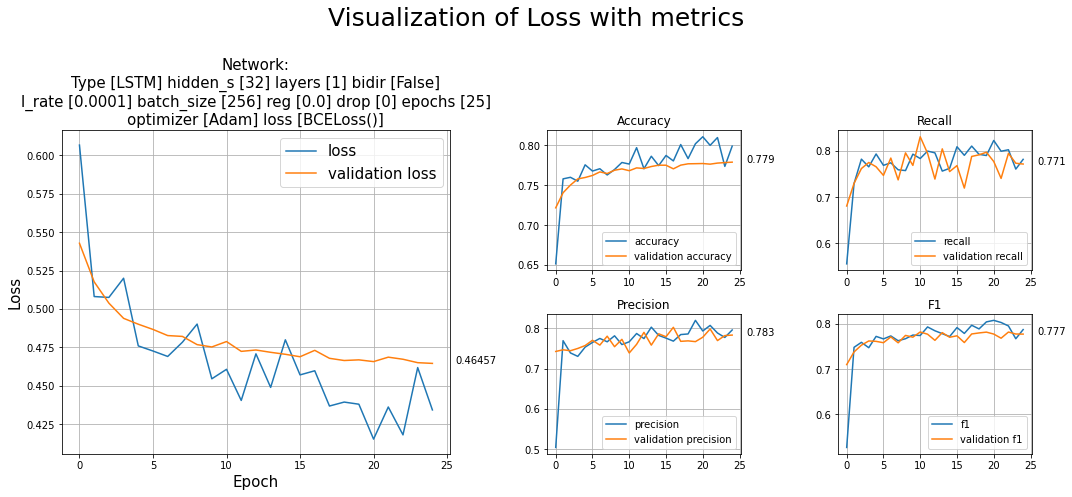

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 32
        self.num_layers      = 1
        self.bidirectional   = False
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 25

config = Config()


history = train_model(embedding_layer, embeddings_dim, train_embeddings_dataset, validation_embeddings_dataset, device, config, True)
_ = classifier_loss_visualization([history]) 

#### Bidirectional

The bidirectional LSTM with 32 and 64 layers are overfitting a lot so we will add dropout

##### Hidden Size 32

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.05 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Total time: 1252.2216293811798 time per epoch: 50.08886517524719


<Figure size 432x288 with 0 Axes>

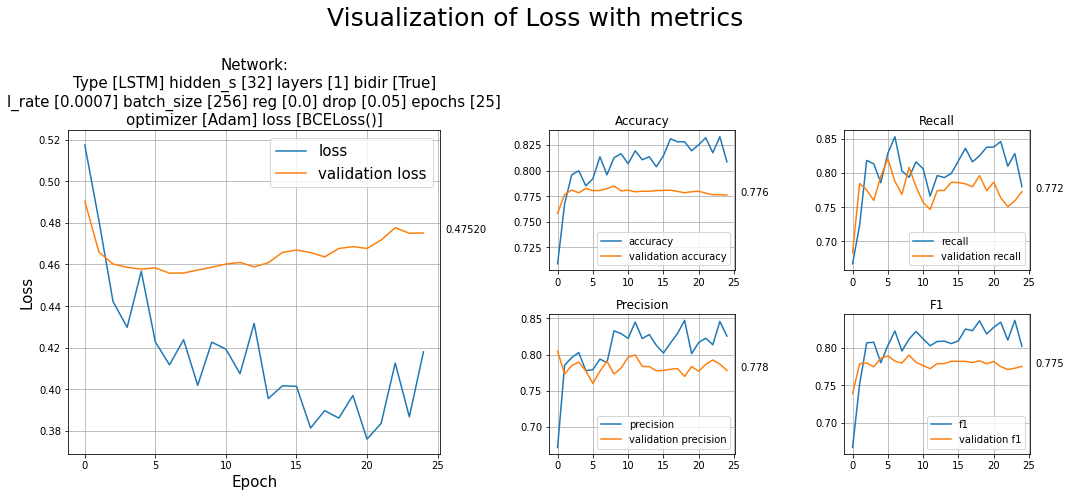

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 32
        self.num_layers      = 1
        self.bidirectional   = True
        self.dropout         = 0.05
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0007
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 25

config = Config()


history = train_model(embedding_layer, embeddings_dim, train_embeddings_dataset, validation_embeddings_dataset, device, config, True, None)
_ = classifier_loss_visualization([history]) 

##### Hidden Size 64

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.05 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Total time: 1287.2450830936432 time per epoch: 51.489803323745726


<Figure size 432x288 with 0 Axes>

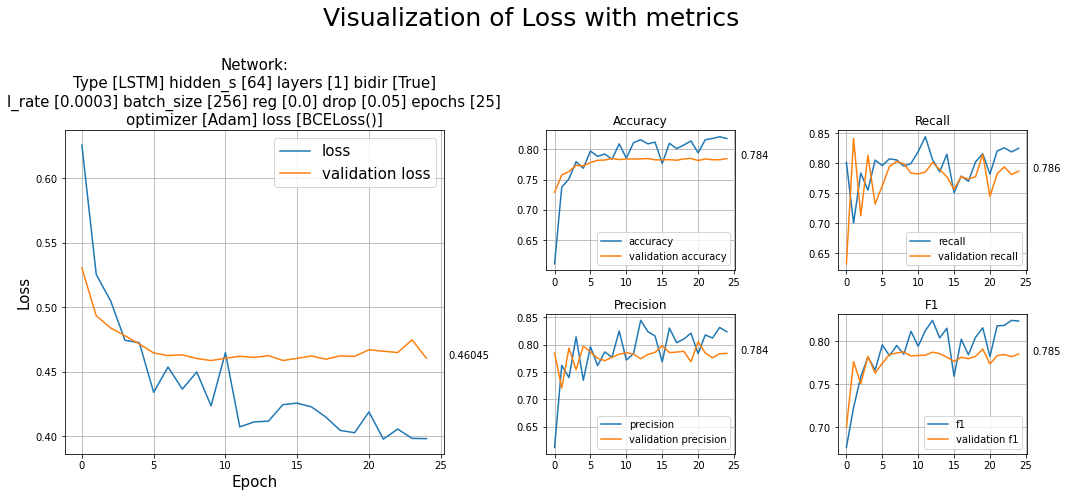

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 64
        self.num_layers      = 1
        self.bidirectional   = True
        self.dropout         = 0.05
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0003
        self.momentum        = 0.9
        self.weight_decay    = 0.00
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 25

config = Config()


history = train_model(embedding_layer, embeddings_dim, train_embeddings_dataset, validation_embeddings_dataset, device, config, True)
_ = classifier_loss_visualization([history]) 

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Total time: 1298.2347354888916 time per epoch: 51.92938941955566


<Figure size 432x288 with 0 Axes>

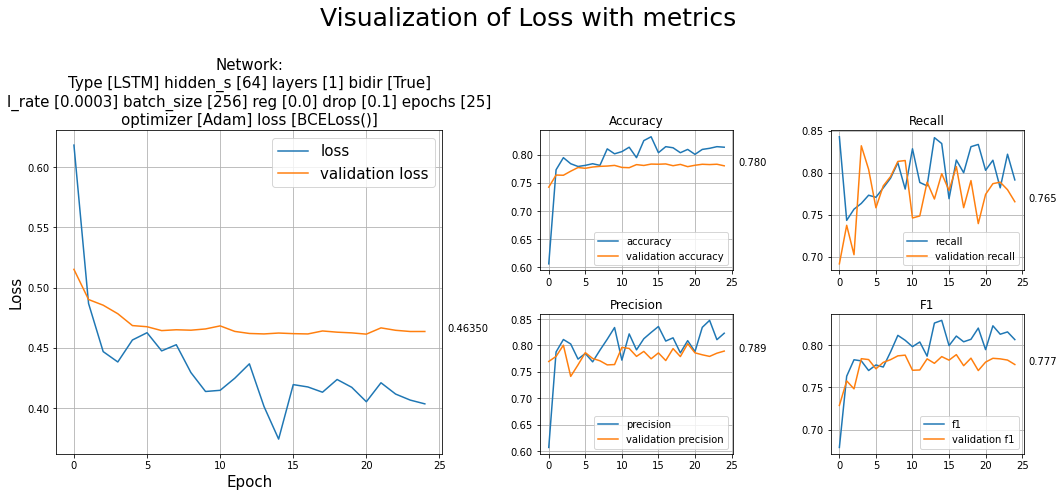

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 64
        self.num_layers      = 1
        self.bidirectional   = True
        self.dropout         = 0.1
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0003
        self.momentum        = 0.9
        self.weight_decay    = 0.00
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 25

config = Config()


history = train_model(embedding_layer, embeddings_dim, train_embeddings_dataset, validation_embeddings_dataset, device, config, True)
_ = classifier_loss_visualization([history]) 

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Total time: 1295.088861465454 time per epoch: 51.803554458618166


<Figure size 432x288 with 0 Axes>

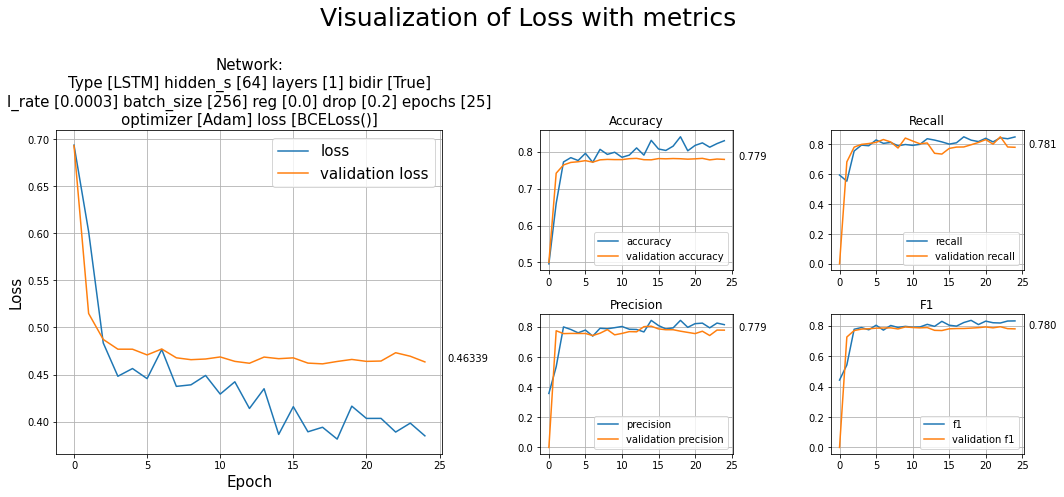

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 64
        self.num_layers      = 1
        self.bidirectional   = True
        self.dropout         = 0.2
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0003
        self.momentum        = 0.9
        self.weight_decay    = 0.00
        self.gradient_clip   = 1
        self.batch_size      = 256
        self.test_batch_size = 2048
        self.epochs          = 25

config = Config()


history = train_model(embedding_layer, embeddings_dim, train_embeddings_dataset, validation_embeddings_dataset, device, config, True)
_ = classifier_loss_visualization([history]) 

## Self attention results

From the tested models and parameters, we couldn't find a model that performed better than the non-attention model having a simple sigmoid function at the last RNN block.

However, the self-attention model could learn faster and, it converged at faster rates than the simple sentiment classification model.

Although it was prone to more overfitting because the model could learn faster by ignoring parts of the sentence that didn't have important contextual meaning.

As for the accuracy, it did not add that much up. Maybe the pre-trained embeddings from a language model may be better at increasing the accuracy of the model.

# Embeddings from Language Model ELMo

Embeddings from a language model are superior to the word 2 vec embeddings because they take into consideration a lot of contextual meaning rather than the nearby words. 

The pre-trained model that will be used is described in [(Peters at el., 2018)](https://www.aclweb.org/anthology/N18-1202/). For the pre-trained model, the [allennlp library](https://allennlp.org/elmo) will be used.

We will train the LSTM model using the full 5.5B pre-trained model and also with the small pre-trained model with the full dataset of 1.2 million tweets 

## Download libraries

In [ ]:
!pip freeze | grep dataclasses
!pip install allennlp

## Dataset for the ELMo and tokenizer

In [ ]:
class Elmo_Dataset(torch.utils.data.Dataset):
    # vectorize data
    def __init__(self, corpus, labels):
        self.labels = labels
        self.corpus = []
        # tokenize words
        for sentence in corpus:
            self.corpus.append([word for word in sentence.split()])

    def __len__(self):
        return len(self.corpus)

    def __getitem__(self, index):
        # Load data and get label
        x = self.corpus[index]
        y = self.labels[index]
        return x, y

def elmo_tokenizer(batch):
    data   = [item[0] for item in batch]
    target = [item[1] for item in batch]
    # return batch_to_ids(data).type(torch.float32), torch.tensor(target, dtype=torch.float32).reshape(-1,1)
    return batch_to_ids(data), torch.tensor(target, dtype=torch.float32).reshape(-1,1)


## Model that uses the elmo embedding layer

In [ ]:
class RNN_Model(torch.nn.Module):

    def __init__(self, RNN_type, embedding_layer, input_size, hidden_size, num_layers, bidirectional=False, dropout=0):
        # torch module
        super(RNN_Model, self).__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size
        if bidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1
        
        # embeddings
        self.embedding = embedding_layer

        # RNN type model
        if RNN_type == "simpleRNN":
            self.rnn = nn.RNN(input_size, hidden_size, num_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        elif RNN_type == "GRU":
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        elif RNN_type == "LSTM":
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # linear and sigmoid layer
        self.fc  = nn.Linear(self.hidden_size*self.num_directions, 1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        batch_size = x.size(0)
        
        # embeddings and rnn
        embeds = self.embedding(x)["elmo_representations"][0]
        # print(embeds.size(), embeds.requires_grad)
        rnn_out, _ = self.rnn(embeds)
        
        # stack up rnn outputs
        rnn_out = rnn_out.contiguous().view(-1, self.hidden_size*self.num_directions)
        
        # dropout and fully connected layer
        out = self.dropout(rnn_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        sig_out = sig_out.view(-1, 1)
        # print(sig_out.size(), embeds.requires_grad)
        # return last sigmoid output and ignore hidden state
        return sig_out


## Getting new dataset for the elmo embeddings

In [ ]:
train_elmo_dataset      = Elmo_Dataset(x_train_corpus, y_train_list)
validation_elmo_dataset = Elmo_Dataset(x_validation_corpus, y_validation_list)
test_elmo_dataset       = Elmo_Dataset(x_test_corpus, y_test_list)

## Train with Elmo embeddings

Training takes a very very long time with one gpu and 1200000 sentences to train with.

With 5.5B parameters each epoch took about 35 minutes with GPU utilization at 100%

Also with the limitations of google colab the training couldn't last for longer periods.

### Train with the big pretraind elmo model 5.5B parameters

Downloading the pre-trainde language model and setting grads to False so it is untrainble

In [ ]:
from allennlp.modules.elmo import Elmo, batch_to_ids
# big elmo model
elmo_weights = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway_5.5B/elmo_2x4096_512_2048cnn_2xhighway_5.5B_weights.hdf5"
elmo_options = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway_5.5B/elmo_2x4096_512_2048cnn_2xhighway_5.5B_options.json"

# get the pretraimed elmo model
elmo = Elmo(weight_file=elmo_weights, options_file=elmo_options, num_output_representations=1)
for param in elmo.parameters():
    param.requires_grad = False

downloading: 100%|##########| 374434792/374434792 [00:05<00:00, 73133635.94B/s]
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


We will test the best configuration from the previous experimets with different learning rates.


For 10 epochs and 256 mini-batch size due to memory and time limitations.



Firstly with a 0.0003 learning rate the model seems very promising as it passes 0.79 accuracy mark at only 3 epochs while the simple glove embedding model required more than 20 epochs to reach 0.78 accuracy

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


Total time: 11678.129404067993 time per epoch: 1946.3549006779988


<Figure size 432x288 with 0 Axes>

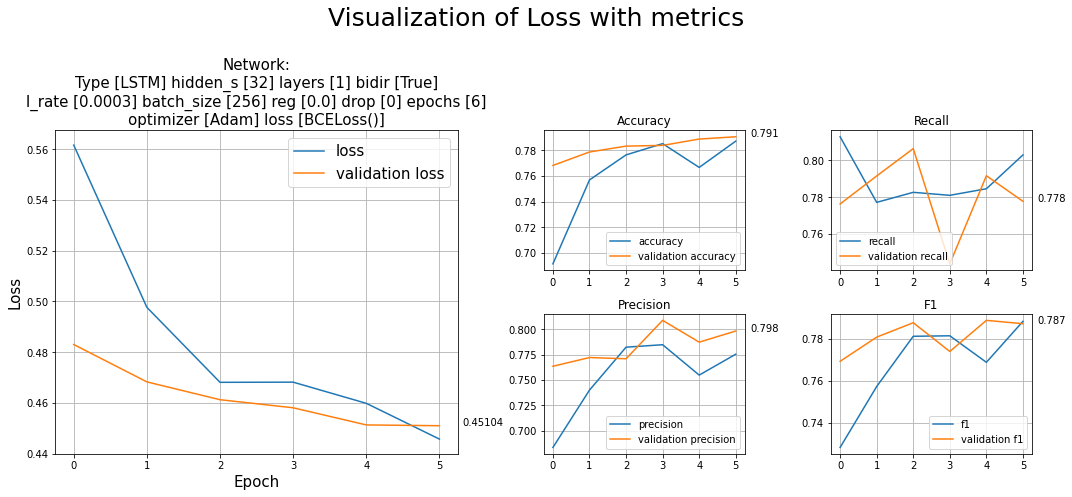

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 32
        self.num_layers      = 1
        self.bidirectional   = True
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0003
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 5
        self.batch_size      = 256
        self.test_batch_size = 256
        self.epochs          = 6

config = Config()


history = train_model(elmo, 1024, train_elmo_dataset, validation_elmo_dataset, device, config, True, elmo_tokenizer)
_ = classifier_loss_visualization([history]) 

By increasing the learning rate at 0.0005 we can observe an acceleration at the convergence rate with grater scores at the same epochs.

Also the training curves have great ups and downs while the validation curves are a lot smoother.

This might be explainde from the grate dropout rate that the pre-trained elmo model has. Droout rate is deactivated during validation and can produce more consisnte resulusts without overfitting

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


Total time: 19802.79573750496 time per epoch: 1980.279573750496


<Figure size 432x288 with 0 Axes>

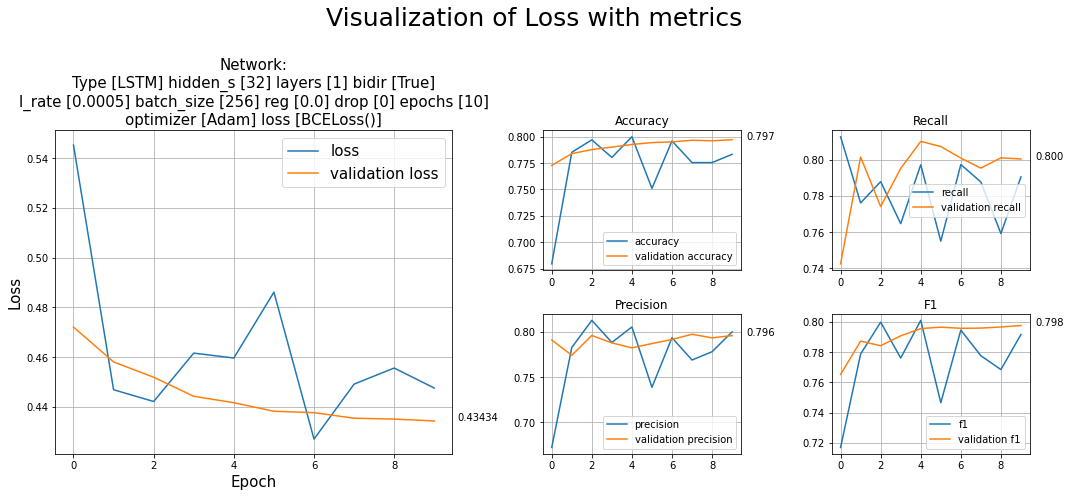

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 32
        self.num_layers      = 1
        self.bidirectional   = True
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0005
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 5
        self.batch_size      = 256
        self.test_batch_size = 256
        self.epochs          = 10

config = Config()


history = train_model(elmo, 1024, train_elmo_dataset, validation_elmo_dataset, device, config, True, elmo_tokenizer)
_ = classifier_loss_visualization([history]) 

By increasing more at 0.001 we can see for the fisrt time 0.8 validation accuracy scores

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


Total time: 18608.171437740326 time per epoch: 1860.8171437740325


<Figure size 432x288 with 0 Axes>

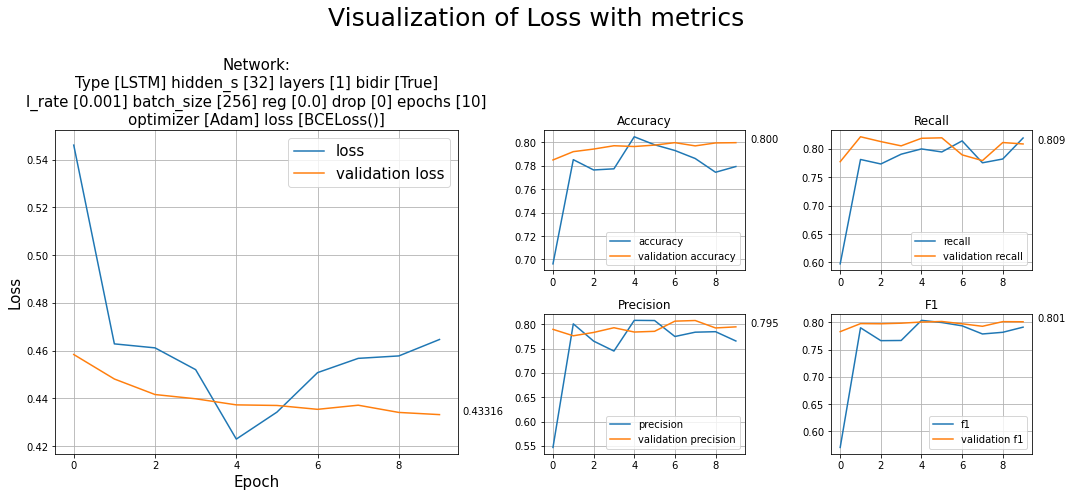

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 32
        self.num_layers      = 1
        self.bidirectional   = True
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 5
        self.batch_size      = 256
        self.test_batch_size = 256
        self.epochs          = 10

config = Config()


history = train_model(elmo, 1024, train_elmo_dataset, validation_elmo_dataset, device, config, True, elmo_tokenizer)
_ = classifier_loss_visualization([history]) 

### Train with bigger hidden layers 

Elmo embeddings can produce a vector of size 1024 for every word in a sentence. The glove embeddings only have a vector of size 300.  By increasing the hidden layer size using the glove embeddings we could only see overfitting without any improvement of the score. Now by having all that extra information per word we could increase the RNN size of hidden layers and see if we could enhance the performance of the model.

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


Total time: 10118.839777708054 time per epoch: 2023.7679555416107


<Figure size 432x288 with 0 Axes>

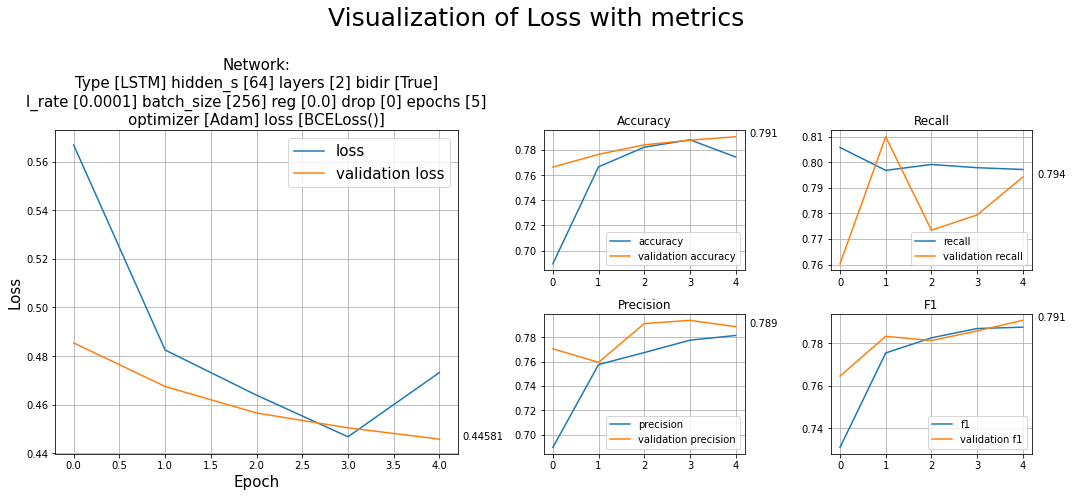

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 64
        self.num_layers      = 2
        self.bidirectional   = True
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 5
        self.batch_size      = 256
        self.test_batch_size = 256
        self.epochs          = 5

config = Config()


history = train_model(elmo, 1024, train_elmo_dataset, validation_elmo_dataset, device, config, True, elmo_tokenizer)
_ = classifier_loss_visualization([history]) 

Training with 256 hidden layer size. These models took a lot of time to train.

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


Total time: 20184.52159523964 time per epoch: 2018.452159523964


<Figure size 432x288 with 0 Axes>

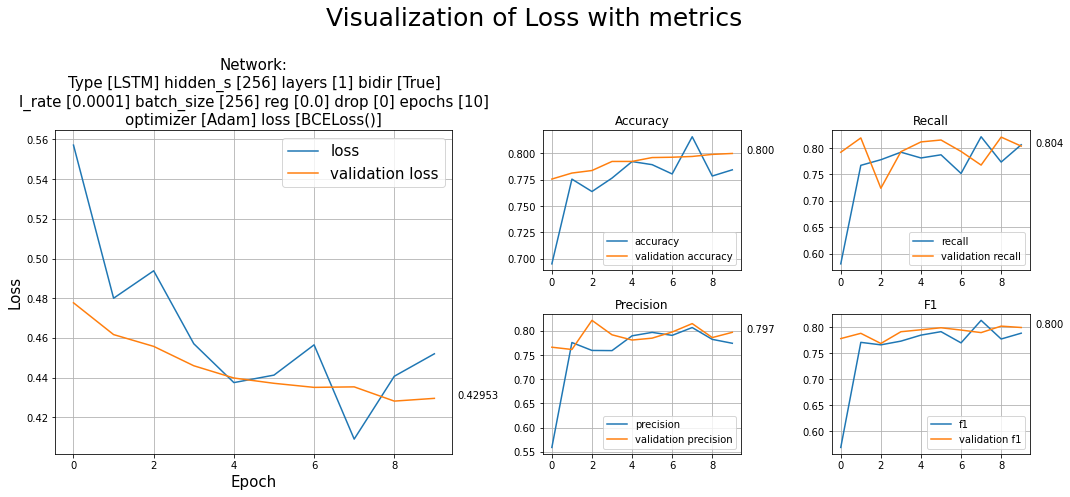

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 256
        self.num_layers      = 1
        self.bidirectional   = True
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 5
        self.batch_size      = 256
        self.test_batch_size = 256
        self.epochs          = 10

config = Config()


history = train_model(elmo, 1024, train_elmo_dataset, validation_elmo_dataset, device, config, True, elmo_tokenizer)
_ = classifier_loss_visualization([history]) 

It seems that having a bigger model with Elmo embeddings is effective. For the first time, we scored a consistent score of 0.8 more than any other test. The Elmo embeddings can produce a lot of contextual information that large networks may exploit that.

Also at 10 epochs there hasn't any noticeable overfitting. However, the train score was lower due to dropout.

Another point to mention is the learning rate which is small. Having a greater learning rate could train the model faster, although it may diverge the model.
This is what we will try with the next run.

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


Total time: 19363.409574985504 time per epoch: 1936.3409574985503


<Figure size 432x288 with 0 Axes>

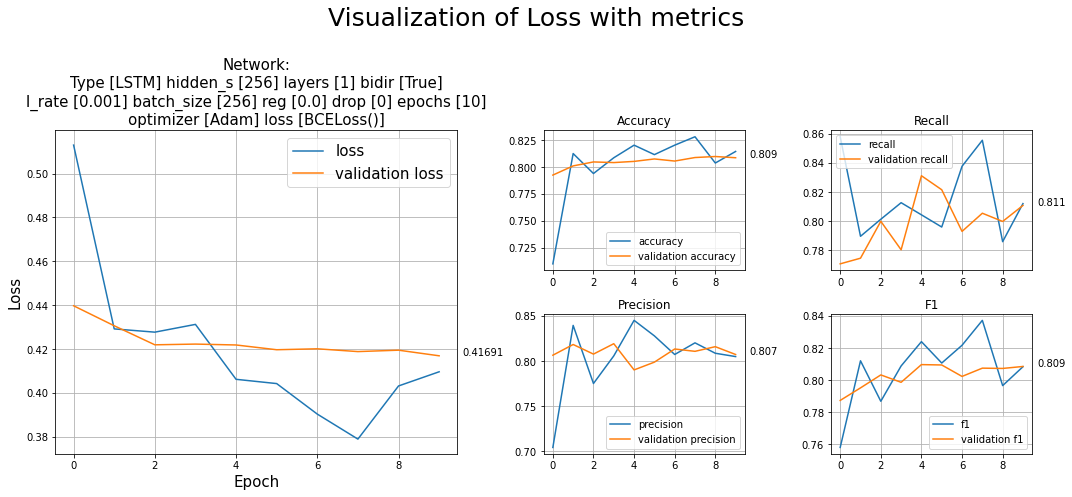

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 256
        self.num_layers      = 1
        self.bidirectional   = True
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 5
        self.batch_size      = 256
        self.test_batch_size = 256
        self.epochs          = 10

config = Config()


history = train_model(elmo, 1024, train_elmo_dataset, validation_elmo_dataset, device, config, True, elmo_tokenizer)
_ = classifier_loss_visualization([history]) 

Having a greater learning rate made the model converge faster however, it also was slightly overfitting. 

Now we will try 512 hidden layer size with a learning rate between the 0.001 and 0.0001 marks.

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


Total time: 23380.028879642487 time per epoch: 2338.0028879642487


<Figure size 432x288 with 0 Axes>

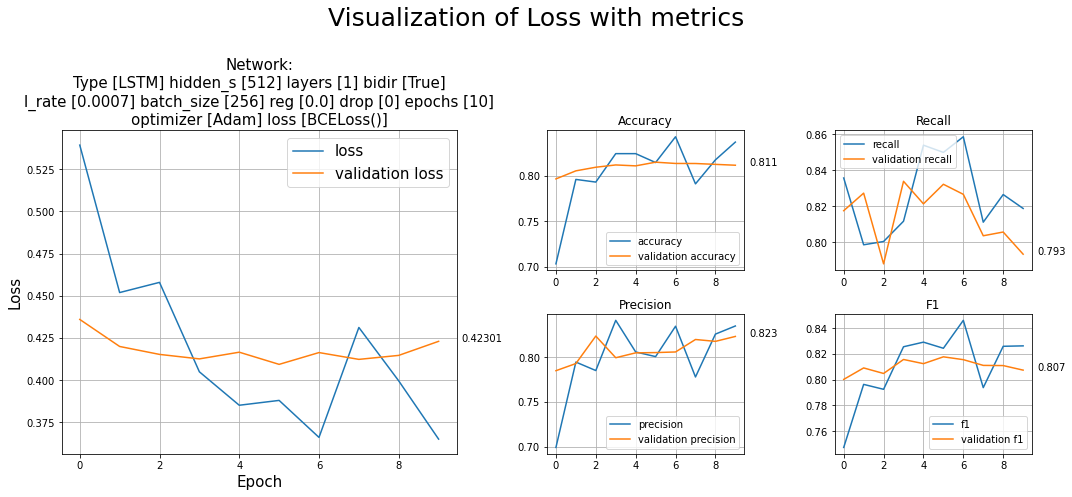

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 512
        self.num_layers      = 1
        self.bidirectional   = True
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0007
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 5
        self.batch_size      = 256
        self.test_batch_size = 256
        self.epochs          = 10

config = Config()


history = train_model(elmo, 1024, train_elmo_dataset, validation_elmo_dataset, device, config, True, elmo_tokenizer)
_ = classifier_loss_visualization([history]) 

512 hidden layer size gave us the best results from all the previous experiments. The model even reached a validation accuracy of 0.85 but from that point and on the model was overfitting and it reduced its validation accuracy.

For that reason, we may try to early stop it at 5 epochs only.

A further examination of dropout ar l2 regularization is practically forbidden caus the model took 7 hours to train which is just enough for a Google Colab GPU Runtime.

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


Total time: 11415.314128875732 time per epoch: 2283.0628257751464


<Figure size 432x288 with 0 Axes>

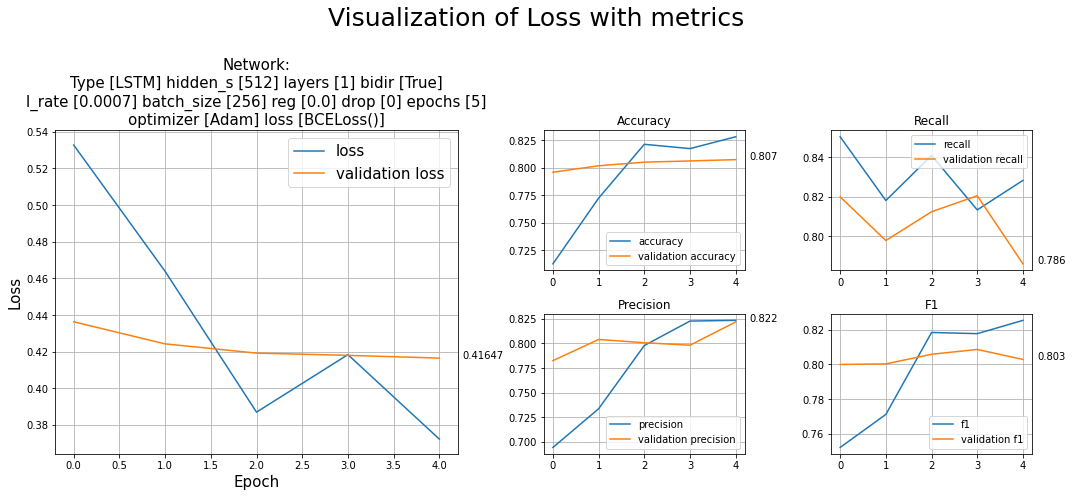

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 512
        self.num_layers      = 1
        self.bidirectional   = True
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0007
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 5
        self.batch_size      = 256
        self.test_batch_size = 256
        self.epochs          = 5

config = Config()


history = train_model(elmo, 1024, train_elmo_dataset, validation_elmo_dataset, device, config, True, elmo_tokenizer)
_ = classifier_loss_visualization([history]) 

Keep this as the best model to calculate the classification report and the ROC plot.

The best performing model was the previous one but it was overfitting so we will pick this one that has not started to overfitting yet.

In [ ]:
best_model = history["model"]

### Train with the small pretrained model 

The smaller pre-trained model was only about 30% faster however it was not better results from the original 5.5B pretrained model.

However, being faster didn't mean that it was better. The model was underperforming against the big pre-trained model.

In [ ]:
# small elmo model
elmo_weights = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x1024_128_2048cnn_1xhighway/elmo_2x1024_128_2048cnn_1xhighway_weights.hdf5"
elmo_options = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x1024_128_2048cnn_1xhighway/elmo_2x1024_128_2048cnn_1xhighway_options.json"

# get the pretraimed elmo model
elmo = Elmo(weight_file=elmo_weights, options_file=elmo_options, num_output_representations=1)
for param in elmo.parameters():
    param.requires_grad = False

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


Total time: 4741.893433570862 time per epoch: 1185.4733583927155


<Figure size 432x288 with 0 Axes>

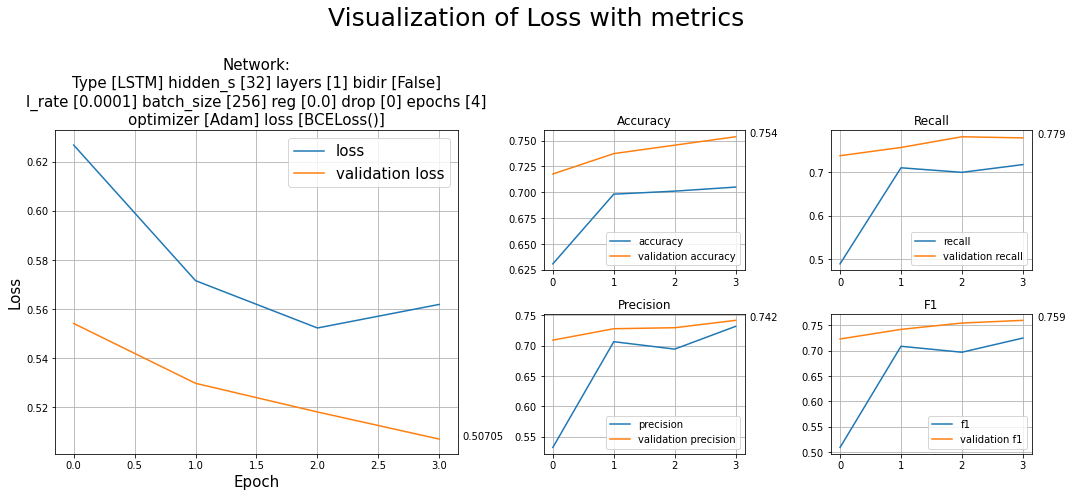

In [ ]:
class Config(object):
    def __init__(self):
        # model
        self.RNN_type        = "LSTM"
        self.hidden_size     = 32
        self.num_layers      = 1
        self.bidirectional   = False
        self.dropout         = 0
 
        # parameters
        self.loss            = nn.BCELoss()
        self.optimizer       = "Adam"
        self.learning_rate   = 0.0001
        self.momentum        = 0.9
        self.weight_decay    = 0.0
        self.gradient_clip   = 10
        self.batch_size      = 256
        self.test_batch_size = 256
        self.epochs          = 4

config = Config()


history = train_model(elmo, 256, train_elmo_dataset, validation_elmo_dataset, device, config, True, elmo_tokenizer)
_ = classifier_loss_visualization([history]) 

## ELMo results

From the testing we can clearly notice that the Embeddings from a Language Model can impove the scores by an remarkable rate. 

A bigger model with 512 hidden layers and more could benefit from the elmo embeddings. 

Also the elmo was using only one layer beacause of memory limitations. Using one more might have even grater results.

# ROC plot and comparison between the RNNs and the feed-forward NNs

## Get the ROC plot from the best model

The Roc plot shows us how many wrong results we will have in each degree of accuracy.

This classifier is not very good but at least we have some results.

ROC plot is produced from the Test set

Getting the ROC score for every batch due to gpu memory limitation.

<class 'torch.Tensor'> torch.Size([31744, 1]) cuda:0


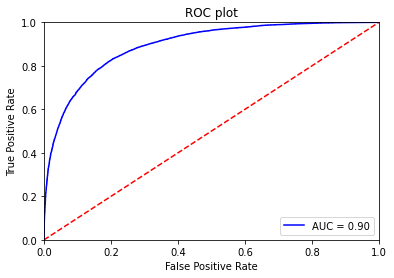

In [ ]:
test_dataloader = DataLoader(test_elmo_dataset, batch_size=256, shuffle=True, pin_memory=True, num_workers=4, drop_last=True, collate_fn=elmo_tokenizer)

# test per batch partially for memory limiatations
ouput_list = []
labels_list = []
with torch.no_grad():
    for data, labels in test_dataloader:
        # Load the data and labels from the test dataset
        data, labels = data.to(device), labels.to(device)
        output = best_model(data)
        ouput_list.append(output)
        labels_list.append(labels)

# concat output of test set
test_output = torch.cat(ouput_list, 0)
test_labels = torch.cat(labels_list, 0)
print(type(test_output), test_output.size(), test_output.device)

get_roc_plot(test_labels.cpu(), test_output.cpu())

## ROC plot from the previous project using a simple feed forward Neural Net

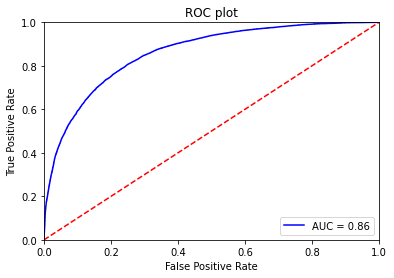

## Get the classification report

In [ ]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(test_labels.cpu().numpy(), torch.round(test_output).cpu().numpy(), target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.80      0.84      0.82     15867
     class 1       0.83      0.79      0.81     15877

    accuracy                           0.81     31744
   macro avg       0.81      0.81      0.81     31744
weighted avg       0.81      0.81      0.81     31744



## Comparison of the RNN with the Feed Forward NN

The best simple Feed Forward Neural Network could achieve a test set accuracy of 0.78. This score was produced using the embedding layer and by choosing the ideal network size to reduce overfitting.

The RNNs LSTM and GRU alone could not overcome this score, proving that a simple neural network is a hard benchmark to beat. The best these models could achieve has around the best feed-forward network.

As for the hyperparameters, we could notice a similar trend with the feed-forward NNs as bigger layers and more parameters were causing overfitting, and dropout or weight decay was needed. Even the dropout rate of high could intervene with the model's convergence. The best combination was a small hidden layer size.

Adding self-attention to the model didn't offer any improvement. This might be due to the limited resources for the better tuning of its hyperparameters, or the dataset might be too hard to extract contextual information from it. Even more, the self-attention model was more prone to overfitting, which might unveil a weird pattern of the dataset.

Elmo embeddings brought a significant improvement to the performance. The bidirectional LSTM that each direction was trained separately could provide information from this incomprehensible dataset.
We used only one Elmo layer from its stacked LSTM layers due to memory and time limitations. The best model took about 7 hours to train. Even with one Elmo layer, we could achieve consistently greater validation scores of 0.8.

However, from 20 minutes we went to 7 hours to only gain 0.03 percent improvement. By having more resources we could tune the Elmo model better and get better scores.

Transfer learning with RNNs was the most effective way to get the best results.